### Imports

In [1]:
import itertools
from tqdm.auto import tqdm, trange
import random
import os
import sys
from io import StringIO
from IPython import get_ipython


import torch
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset

from pyvene import(
    CausalModel, IntervenableModel, IntervenableConfig,
    RepresentationConfig, RotatedSpaceIntervention
)

from transformers import (
    AutoTokenizer, get_scheduler,
    AutoModelForCausalLM, GPT2LMHeadModel
)

from accelerate import Accelerator
from accelerate.utils import set_seed

In [2]:
"""
# ipython_exit.py
Allows exit() to work if script is invoked with IPython without
raising NameError Exception. Keeps kernel alive.

Use: import variable 'exit' in target script with
     'from ipython_exit import exit'    
"""

class IpyExit(SystemExit):
    """Exit Exception for IPython.

    Exception temporarily redirects stderr to buffer.
    """
    def __init__(self):
        # print("exiting")  # optionally print some message to stdout, too
        # ... or do other stuff before exit
        sys.stderr = StringIO()

    def __del__(self):
        sys.stderr.close()
        sys.stderr = sys.__stderr__  # restore from backup


def ipy_exit():
    raise IpyExit


if get_ipython():    # ...run with IPython
    exit = ipy_exit  # rebind to custom exit
else:
    exit = exit      # just make exit importable

### Hyperparameters

In [3]:
seed = 42
mixed_precision = 'no'  # choose from no, fp16, bf16 or fp8
# needed for dataset generation in case of counterfactual dataset
batch_size = 8

set_seed(seed)

### Special variables

In [4]:
# Longest command is 9 words : https://arxiv.org/pdf/1711.00350
max_command_len = 9
# dummy tokens for formatting
EMPTY = "<empty>" # "EMPTY"
PORT = "<port>"
ACT = "<act>"

### Causal Model

In [5]:
# command type maps
actions = {
    "walk": "I_WALK",
    "run": "I_RUN",
    "jump": "I_JUMP",
    "look": "I_LOOK",
    "turn": EMPTY,
    EMPTY: EMPTY,
    }

turns = {
    "around": "yyyy",
    "opposite": "yy",
    EMPTY: EMPTY
}

directions = {
    "right": "I_TURN_RIGHT",
    "left": "I_TURN_LEFT",
    EMPTY: EMPTY
}

nums = {
    "twice": "xx",
    "thrice": "xxx",
    EMPTY: EMPTY
}

conjs = ["and", "after", EMPTY]

# command structure
command_structure = {
    0: actions,
    1: turns,
    2: directions,
    3: nums,
    4: conjs,
    5: actions,
    6: turns,
    7: directions,
    8: nums,
}


### VARIABLES ###

# longest command is 9 words : https://arxiv.org/pdf/1711.00350
# This ordering (left to right) is important for downstream code!
leaves = [
    "act1", "trn1", "dir1", "num1",
    "conj",
    "act2", "trn2", "dir2", "num2"
]
non_leaves = [
    "trn1_res", "trn1_dir1", "act1_trn1_dir1", 
    "num1_res", "act1_trn1_dir1_num1",
    "trn2_res", "trn2_dir2", "act2_trn2_dir2", 
    "num2_res", "act2_trn2_dir2_num2",
    "conj_left", "conj_right",
]
variables = leaves + non_leaves

### FUNCTIONS ###

def resolve_turn(turn):
    return turns[turn]

# need to represent ACT differently?
def turn_function(turn, dir):
    dir = directions[dir]
    if dir == EMPTY:
        return EMPTY
    elif turn == EMPTY:
        dec_act = dir + ' '+ACT+' '
    elif turn == "yyyy":
        dec_act = (dir + ' '+ACT+' ')*len(turn) 
    else:
        dec_act = (dir + ' ')*len(turn) + ACT
    return dec_act.strip()

def action_function(act, trn_dir):
    if trn_dir == EMPTY:
        return actions[act]
    return (trn_dir.replace(ACT, actions[act])).strip()

def resolve_num(num):
    return nums[num]

def num_function(act_trn_dir, num):
    if num == EMPTY:
        return act_trn_dir
    dec = (act_trn_dir + ' ') * len(num)
    return dec.strip()

def conjugation_left(act1_trn1_dir1_num1, conj):
    if conj == EMPTY:
        return act1_trn1_dir1_num1
    elif conj == "and":
        return act1_trn1_dir1_num1 + PORT
    else:
        return PORT + act1_trn1_dir1_num1
    

def conjugation_right(conj_left, act2_trn2_dir2_num2):
    if act2_trn2_dir2_num2 == EMPTY:
        f_str = conj_left
    # after
    elif conj_left.startswith(PORT):
        f_str = act2_trn2_dir2_num2 + conj_left
    # and
    else:
        f_str = conj_left + act2_trn2_dir2_num2
    f_str = f_str.replace(PORT, ' ')
    f_str = f_str.replace((' '+EMPTY+' '), ' ')
    f_str = f_str.replace(EMPTY, '')
    return f_str.strip()

functions = {

    # leaves
    "act1": lambda x: x,
    "act2": lambda x: x,
    "trn1": lambda x: x,
    "trn2": lambda x: x,
    "dir1": lambda x: x,
    "dir2": lambda x: x,
    "num1": lambda x: x,
    "num2": lambda x: x,
    "conj": lambda x: x,

    # resolving turn
    "trn1_res": resolve_turn,
    "trn2_res": resolve_turn,

    # combining turn and direction
    "trn1_dir1": turn_function,
    "trn2_dir2": turn_function,

    # combining turn_direction and action
    "act1_trn1_dir1": action_function,
    "act2_trn2_dir2": action_function,

    # resolving num
    "num1_res": resolve_num,
    "num2_res": resolve_num,

    # combining action_turn_direction and num
    "act1_trn1_dir1_num1": num_function,
    "act2_trn2_dir2_num2": num_function,

    # conj with left segment
    "conj_left": conjugation_left,

    # conj with right segment
    "conj_right": conjugation_right,
}


### VALUES ###

values = dict()

# leaves
values["act1"] = list(actions.keys())
values["act2"] = list(actions.keys())
values["trn1"] = list(turns.keys())
values["trn2"] = list(turns.keys())
values["dir1"] = list(directions.keys())
values["dir2"] = list(directions.keys())
values["num1"] = list(nums.keys())
values["num2"] = list(nums.keys())
values["conj"] = conjs


# resolve turn
values["trn1_res"] = [resolve_turn(t) for t in values["trn1"]]
values["trn2_res"] = values["trn1_res"].copy()

# turn+dir
all_trn_dir = list(itertools.product(values["trn1_res"], values["dir1"]))
values["trn1_dir1"] = list(set([turn_function(tup[0], tup[1]) for tup in all_trn_dir]))
values["trn2_dir2"] = values["trn1_dir1"].copy()

# act+turn_dir
all_act_trn_dir = list(itertools.product(values["act1"], values["trn1_dir1"]))
values["act1_trn1_dir1"] = list(set([action_function(tup[0], tup[1]) for tup in all_act_trn_dir]))
values["act2_trn2_dir2"] = values["act1_trn1_dir1"].copy()

# resolve num
values["num1_res"] = [resolve_num(n) for n in values["num1"]]
values["num2_res"] = values["num1_res"].copy()

# act_turn_dir+num
all_act_trn_dir_num = list(itertools.product(values["act1_trn1_dir1"], values["num1_res"]))
values["act1_trn1_dir1_num1"] = list(set([num_function(tup[0], tup[1]) for tup in all_act_trn_dir_num]))
values["act2_trn2_dir2_num2"] = values["act1_trn1_dir1_num1"].copy()

# conj_left
all_conj_left = list(itertools.product(values["act1_trn1_dir1_num1"], conjs))
values["conj_left"] = list(set([conjugation_left(tup[0], tup[1]) for tup in all_conj_left]))

# conj_right
all_conj_right = list(itertools.product(values["conj_left"], values["act2_trn2_dir2_num2"]))
values["conj_right"] = list(set([conjugation_right(tup[0], tup[1]) for tup in all_conj_right]))


### PARENTS ###

parents = {v:[] for v in variables}
# left subtree
parents["trn1_res"] = ["trn1"]
parents["trn1_dir1"] = ["trn1_res", "dir1"]
parents["act1_trn1_dir1"] = ["act1", "trn1_dir1"]
parents["num1_res"] = ["num1"]
parents["act1_trn1_dir1_num1"] = ["act1_trn1_dir1", "num1_res"]
# right subtree
parents["trn2_res"] = ["trn2"]
parents["trn2_dir2"] = ["trn2_res", "dir2"]
parents["act2_trn2_dir2"] = ["act2", "trn2_dir2"]
parents["num2_res"] = ["num2"]
parents["act2_trn2_dir2_num2"] = ["act2_trn2_dir2", "num2_res"]
# merge
parents["conj_left"] = ["act1_trn1_dir1_num1", "conj"]
parents["conj_right"] = ["conj_left", "act2_trn2_dir2_num2"]


### POSITIONS ###

# a dictionary with nodes as keys and positions as values
pos = {

    # left subtree
    "act1": (1, 0),
    "trn1": (2, 0),
    "dir1": (1.9, 0.05),
    "num1": (4, 0),
    "conj": (4.11, 0.1),
    "act1": (0.2, 0),
    "trn1": (1, 0.1),
    "trn1_res": (1.33, 0.4),
    "dir1": (2, 0.3),
    "num1": (2.8, 0),
    "num1_res": (3, 0.2),
    "trn1_dir1": (1.4, 0.96),
    "act1_trn1_dir1": (0.2, 1.5),
    "act1_trn1_dir1_num1": (2.5, 1.8),

    # right subtree
    "act2": (5, 0),
    "trn2": (6, 0),
    "dir2": (5.9, 0.05),
    "num2": (9, 0),
    "act2": (5.2, 0),
    "trn2": (6, 0.1),
    "trn2_res": (6, 0.4),
    "dir2": (7, 0.3),
    "num2": (9.8, 0),
    "num2_res": (9, 0.2),
    "trn2_dir2": (6.4, 1),
    "act2_trn2_dir2": (5.2, 1.5),
    "act2_trn2_dir2_num2": (7.5, 1.8),

    # merge
    "conj_left": (3.5, 2.2),
    "conj_right": (4.5, 3.2),
}

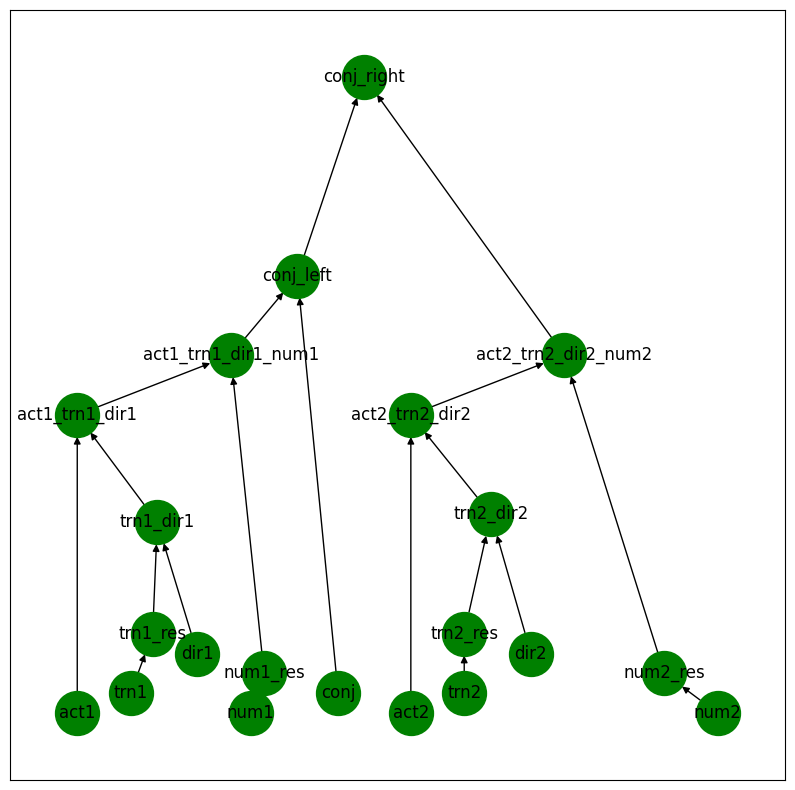

In [6]:
causal_model = CausalModel(variables, values, parents, functions, pos=pos)
causal_model.print_structure()

### Load dataset

In [7]:
# dataset splits
scan_simple = load_dataset('scan', 'simple', trust_remote_code=True)

# train and test splits
simple_train = scan_simple['train']
simple_test = scan_simple['test']

# cols
column_names = simple_train.column_names
input_column = column_names[0]
output_column = column_names[1]

## <sep> token? ##
# padded splits
def add_empty_token(x):
    command_str = x[input_column]
    command = command_str.split()
    padded_command = []
    index = 0
    c = 0
    while index < max_command_len:
        expected_cs = command_structure[index]
        if c < len(command) and command[c] in expected_cs:
            padded_command.append(command[c])
            c += 1
        else:
            padded_command.append(EMPTY)
        index += 1
    
    x[input_column] = ' '.join(padded_command)
    return x

simple_train_padded = simple_train.map(
    add_empty_token,
    batched=False,
    desc="Running tokenizer on dataset",
)
simple_test_padded = simple_test.map(
    add_empty_token,
    batched=False,
    desc="Running tokenizer on dataset",
)

### Intervention examples

#### Causal model with no intervention

base : {'commands': 'run opposite left <empty> after walk <empty> right <empty>', 'actions': 'I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_RUN'}
No intervention:
 defaultdict(None, {'act1': 'run', 'act2': 'walk', 'conj': 'after', 'dir1': 'left', 'dir2': 'right', 'num1': '<empty>', 'num2': '<empty>', 'trn1': 'opposite', 'trn2': '<empty>', 'num1_res': '<empty>', 'num2_res': '<empty>', 'trn1_res': 'yy', 'trn2_res': '<empty>', 'trn1_dir1': 'I_TURN_LEFT I_TURN_LEFT <act>', 'trn2_dir2': 'I_TURN_RIGHT <act>', 'act1_trn1_dir1': 'I_TURN_LEFT I_TURN_LEFT I_RUN', 'act2_trn2_dir2': 'I_TURN_RIGHT I_WALK', 'act1_trn1_dir1_num1': 'I_TURN_LEFT I_TURN_LEFT I_RUN', 'act2_trn2_dir2_num2': 'I_TURN_RIGHT I_WALK', 'conj_left': '<port>I_TURN_LEFT I_TURN_LEFT I_RUN', 'conj_right': 'I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_RUN'}) 



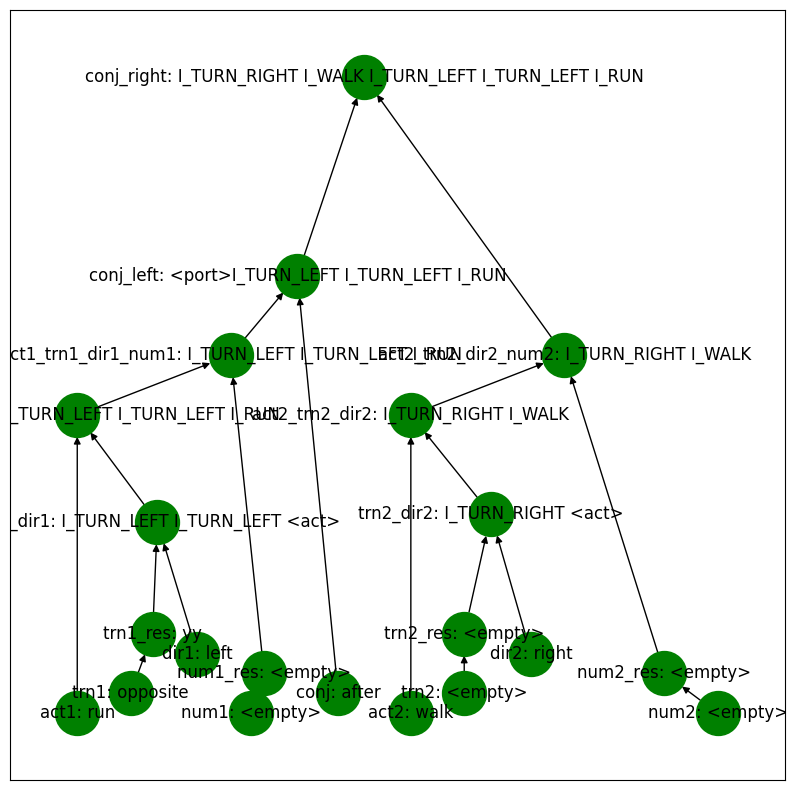

In [83]:
example = simple_train_padded[1]
print('base : {}'.format(example))

padded_command = example[input_column].split()
# assume leaves are correctly ordered from left to right
causal_model_inputs = {leaves[i]:padded_command[i] for i in range(max_command_len)}
base_setting = causal_model.run_forward(causal_model_inputs)
print("No intervention:\n", base_setting, "\n")
causal_model.print_setting(base_setting)

#### Causal model with an intervention

Intervention setting trn2_dir2 to left turn:



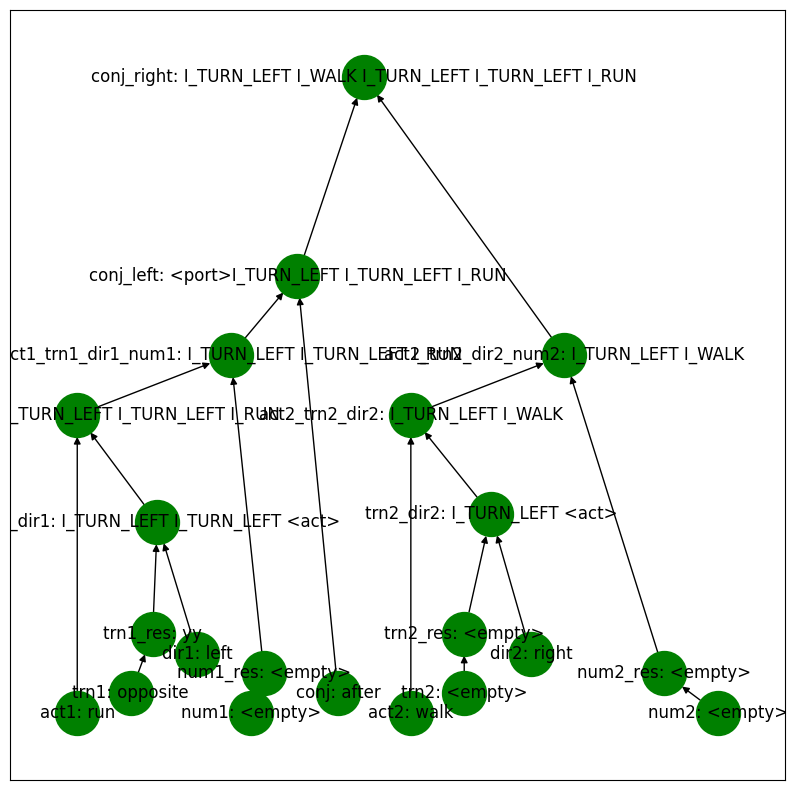

In [84]:
print("Intervention setting trn2_dir2 to left turn:\n",)
## how to do this intervention for gpt? ##
causal_model_inputs['trn2_dir2'] = directions['left'] + ' '+ACT

causal_model.print_setting(causal_model.run_forward(causal_model_inputs))

#### Interchange intervention

base example : {'commands': 'run opposite left <empty> after walk <empty> right <empty>', 'actions': 'I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_RUN'}
source example : {'commands': 'walk <empty> <empty> <empty> after run around right twice', 'actions': 'I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_WALK'}


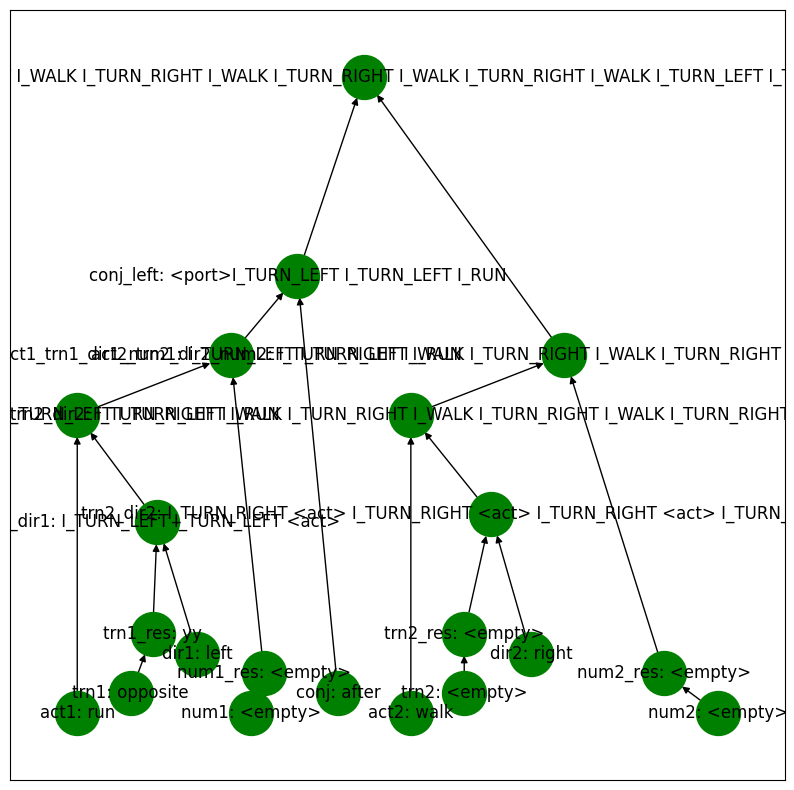

In [85]:
example = simple_train_padded[1]
print('base example : {}'.format(example))
padded_command = example[input_column].split()
base = {leaves[i]:padded_command[i] for i in range(max_command_len)}

source_example = simple_train_padded[2]
print('source example : {}'.format(source_example))
padded_command = source_example[input_column].split()
source = {leaves[i]:padded_command[i] for i in range(max_command_len)}
setting = causal_model.run_interchange(base, {"trn2_dir2": source})
causal_model.print_setting(setting)

In [86]:
print(base_setting['trn2_dir2'])
print(setting['trn2_dir2'])

I_TURN_RIGHT <act>
I_TURN_RIGHT <act> I_TURN_RIGHT <act> I_TURN_RIGHT <act> I_TURN_RIGHT <act>


### Intervention on conj_left

#### Build factual SCAN dataset

Make sure every sample has a conj. Sample each leaf and make sure it's a valid leaf value configuration for the input.

In [87]:
def validate_leaf_config(input):
    # condition1: conj cannot be empty
    if input['conj'] == EMPTY:
        return True
    # condition2 : actions cannot be empty
    if input['act1'] == EMPTY or input['act2'] == EMPTY:
        return True
    # condition3 : if direction is empty, turn has to be empty
    if input['dir1'] == EMPTY and input['trn1'] != EMPTY:
        return True
    if input['dir2'] == EMPTY and input['trn2'] != EMPTY:
        return True


def input_sampler():
    invalid_input = True
    while invalid_input:
        input = {}
        # randomly sample a value at each position
        for posn, val in command_structure.items():
            if isinstance(val, dict):
                command_type_keys = list(val.keys())
            elif isinstance(val, list):
                command_type_keys = val
            else:
                raise ValueError("Invalid command type. Check command type maps")
            r_key = random.choice(command_type_keys)
            # assuming leaves is a list with ordered values
            input[leaves[posn]] = r_key
        # check if sampled example is valid, else sample again
        invalid_input = validate_leaf_config(input)
    return input

#input_sampler()


In [88]:
# len(simple_train_padded) ~ 17k
n_examples = 20000
n_val_examples = 4000
n_test_examples = 4000

# input_ids: {'act1': 'jump', 'trn1': '<empty>', ...}, labels: defaultdict(None, {'act1': 'jump', 'act2': 'jump', ...}
train_examples = causal_model.generate_factual_dataset(
    size=n_examples,
    sampler=input_sampler,
    return_tensors=False
)
val_examples = causal_model.generate_factual_dataset(
    size=n_val_examples,
    sampler=input_sampler,
    return_tensors=False
)
test_examples = causal_model.generate_factual_dataset(
    size=n_test_examples,
    sampler=input_sampler,
    return_tensors=False
)

#### Train GPT2 on generated dataset (all samples with conj)

Hyperparameters and setup

In [89]:
gradient_accumulation_steps = 1
lr = 5e-5
train_steps = 100000
eval_steps = 5000
warmup_steps = 0
num_workers = os.cpu_count()
max_source_length = 512
weight_decay = 0.0
lr_scheduler_type = 'linear'

model_name_or_path = 'openai-community/gpt2'
output_dir = '/home/drdo/Caricatures/models/scan_simple_gen_gpt2'

# initialize accelerator
accelerator = Accelerator(
    mixed_precision=mixed_precision,
    gradient_accumulation_steps=gradient_accumulation_steps,
    log_with="tensorboard",
    project_dir=output_dir
)
# we need to initialize the trackers we use, and also store our configuration
track_config = {
    "lr": lr,
    "train_steps": train_steps,
    "seed": seed,
    "train_batch_size": batch_size,
}
accelerator.init_trackers('runs', track_config)

# tokenizer special tokens
special_tokens_dict = {
    "pad_token": "<pad>",
    "sep_token": "<sep>",
}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Load model and tokenizer

In [90]:
# tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path,)
tokenizer.add_special_tokens(special_tokens_dict)

# model
model = AutoModelForCausalLM.from_pretrained(model_name_or_path,)
# resize the embeddings when necessary to avoid index errors
embedding_size = model.get_input_embeddings().weight.shape[0]
if len(tokenizer) > embedding_size:
    model.resize_token_embeddings(len(tokenizer))

/home/drdo/anaconda3/envs/nlp/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Process generated dataset

In [91]:
# convert examples to Huggingface dataset
train_dataset = Dataset.from_list(train_examples)
val_dataset = Dataset.from_list(val_examples)

# process dataset for gpt input
def process_dataset(x):

    command_list = []
    leaf2comm = x['input_ids']
    # make sure leaves are odered correctly
    for leaf in leaves:
        command_list.append(leaf2comm[leaf])
    command = ' '.join(command_list)

    # only taking final output value
    action = x['labels']['conj_right']
    x['commands'] = command
    x['actions'] = action

    return x


with accelerator.main_process_first():
    train_dataset = train_dataset.map(
        process_dataset,
        batched=False,
        num_proc=1,
        remove_columns=train_dataset.column_names,
    )
    val_dataset = val_dataset.map(
        process_dataset,
        batched=False,
        num_proc=1,
        remove_columns=val_dataset.column_names,
    )

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [92]:
column_names = train_dataset.column_names
input_column = column_names[0]
output_column = column_names[1]

# preprocess dataset
def preprocess_function(examples):
    # commands, actions
    inputs = examples[input_column]
    targets = examples[output_column]

    # tokenize as single sequence separated by special token
    model_inputs = tokenizer(
        [i+tokenizer.sep_token for i in inputs],
        [t+tokenizer.eos_token for t in targets],
        padding='max_length', max_length=max_source_length
    )
    # labels same as inputs. labels shifted right in the model forward by default
    model_inputs['labels'] = model_inputs['input_ids'].copy()
    # set label padding to -100 
    model_inputs['labels'] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in model_inputs['labels']
    ]

    return model_inputs


with accelerator.main_process_first():
    train_dataset = train_dataset.map(
        preprocess_function,
        batched=True,
        num_proc=num_workers,
        remove_columns=column_names,
    )
    val_dataset = val_dataset.map(
        preprocess_function,
        batched=True,
        num_proc=num_workers,
        remove_columns=column_names,
    )

#print(tokenizer.decode(train_dataset[0]['input_ids'], skip_special_tokens=False))

Map (num_proc=32):   0%|          | 0/20000 [00:00<?, ? examples/s]

Map (num_proc=32):   0%|          | 0/4000 [00:00<?, ? examples/s]

Dataloaders, optimizer, scheduler

In [93]:
from transformers import default_data_collator

# data collator and loaders
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=default_data_collator, batch_size=batch_size
)
val_dataloader = DataLoader(
    val_dataset, collate_fn=default_data_collator, batch_size=batch_size
)

# prepare optimizer and schedule (linear warmup and decay)
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": weight_decay,
    },
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=lr)

# scheduler
lr_scheduler = get_scheduler(
    name=lr_scheduler_type,
    optimizer=optimizer,
    num_warmup_steps=warmup_steps * accelerator.num_processes,
    num_training_steps=train_steps * accelerator.num_processes,
)

Train

In [94]:
# prepare everything for accelerator
model, optimizer, train_dataloader, val_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader, lr_scheduler
)

global_step = 0  # tracks total steps
total_loss = 0  # total loss before each eval

accelerator.log({
    "train_batch_size": batch_size,
    "eval_batch_size": batch_size,
    "gpus": accelerator.state.num_processes
},
    step=global_step + 1,
)

In [95]:
# main progress bar
progress_bar = tqdm(range(global_step, train_steps), disable=not accelerator.is_main_process, position=0)
# val bar
val_bar = tqdm(range(len(val_dataloader)), position=1)

while True:

    model.train()

    for batch in train_dataloader:
        with accelerator.accumulate(model):
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.detach().float()
            accelerator.backward(loss)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        # checks if the accelerator has performed an optimization step behind the scenes
        if accelerator.sync_gradients:
            progress_bar.update(1)

        if (global_step + 1) % eval_steps == 0:
            model.eval()
            val_loss = 0
            
            for batch in val_dataloader:
                with torch.no_grad():
                    outputs = model(**batch)
                    val_loss += outputs.loss.item()

                val_bar.update(1)

            val_bar.refresh()
            val_bar.reset()

            accelerator.print('step : {}, val loss  : {}'.format(global_step + 1, val_loss/len(val_dataloader)))
            accelerator.log({
                "train_loss": total_loss / (eval_steps * accelerator.state.num_processes * batch_size),
                "val_loss": val_loss / len(val_dataloader)
            },
                step=global_step + 1,
            )

            # save the model, optimizer, lr_scheduler, and seed states by calling `save_state`
            # saved to folders named `checkpoint-{global_step}`
            # will contain files: "pytorch_model.bin", "optimizer.bin", "scheduler.bin", and "random_states.pkl"
            # if mixed precision was used, will also save a "scalar.bin" file
            c_dir = f"checkpoint-{global_step + 1}"
            if output_dir is not None:
                output_c_dir = os.path.join(output_dir, c_dir)
                accelerator.save_state(output_c_dir)
                # save config
                accelerator.wait_for_everyone()
                unwrapped_model = accelerator.unwrap_model(model)
                # model.config.save_pretrained(output_dir)
                unwrapped_model.config.save_pretrained(
                    output_c_dir, is_main_process=accelerator.is_main_process, save_function=accelerator.save
                )
                tokenizer.save_pretrained(output_c_dir)

            model.train()
            total_loss = 0

        global_step += 1

        if global_step >= train_steps:
            exit()


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### Load trained GPT2 (on original SCAN dataset)

In [7]:
#checkpoint = '/home/drdo/Caricatures/models/scan_distilgpt2/checkpoint-40000'
checkpoint = '/users/ujan/caricatures/models/scan/distilgpt2_40k'
max_gen_length = 512

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = GPT2LMHeadModel.from_pretrained(checkpoint)
model.generation_config.max_length = max_gen_length

In [8]:
#generation_mode = GenerationMode.GREEDY_SEARCH

context = 'run <empty> right twice after walk <empty> right twice'
inputs = tokenizer(context+tokenizer.sep_token, return_tensors="pt")

output = model.generate(**inputs)[0]
output = tokenizer.decode(output, skip_special_tokens=False).replace(context+tokenizer.sep_token, '')
output = output.replace(tokenizer.eos_token, '')
print(output)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(0.5857)
tensor(0.3769)
tensor(-0.8732)
tensor(-1.7571)
tensor(-1.5737)
tensor(3.0455)
tensor(-0.6095)
tensor(-0.3136)
tensor(0.5047)
tensor(1.1002)
tensor(4.9908)
tensor(-2.0095)
tensor(2.2704)
tensor(1.3882)
tensor(2.2488)
tensor(2.5550)
tensor(6.6477)
tensor(5.3688)
tensor(-0.1271)
tensor(-0.7347)
tensor(1.1833)
tensor(-2.4856)
tensor(1.7377)
tensor(-15.5277)
tensor(-1.2699)
tensor(-1.8371)
tensor(-2.4302)
tensor(-4.8668)
tensor(-2.3385)
tensor(-7.5234)
tensor(3.0453)
tensor(2.1534)
tensor(2.1089)
tensor(-2.0775)
tensor(-5.7833)
tensor(-1.1662)
tensor(3.3461)
tensor(2.5142)
tensor(1.8761)
tensor(-2.2517)
tensor(-1.5238)
tensor(-1.4605)
tensor(1.2136)
tensor(1.2974)
tensor(0.1191)
tensor(0.4545)
tensor(0.9875)
tensor(15.4902)
tensor(1.7201)
tensor(3.7010)
tensor(4.0030)
tensor(3.7814)
tensor(4.5352)
tensor(8.2462)
tensor(1.9890)
tensor(1.9789)
tensor(2.5691)
tensor(3.5015)
tensor(2.4367)
tensor(4.5742)
tensor(-3.8592)
tensor(-4.6620)
tensor(-4.2948)
tensor(-5.8736)
tensor(-6.16

#### Eval on generated test data

In [ ]:
# convert examples to Huggingface dataset
test_dataset = Dataset.from_list(test_examples)
# process dataset for gpt input
def process_dataset(x):

    command_list = []
    leaf2comm = x['input_ids']
    # make sure leaves are odered correctly
    for leaf in leaves:
        command_list.append(leaf2comm[leaf])
    command = ' '.join(command_list)

    # only taking final output value
    action = x['labels']['conj_right']
    x['commands'] = command
    x['actions'] = action

    return x


test_dataset = test_dataset.map(
    process_dataset,
    batched=False,
    num_proc=1,
    remove_columns=test_dataset.column_names,
)


column_names = test_dataset.column_names
input_column = column_names[0]
output_column = column_names[1]

testset = test_dataset  #.select(range(100))

count = 0
model.to("cuda")
bar = tqdm(range(len(testset)))
for example in testset:
    command = example[input_column]
    label = example[output_column]
    inputs = tokenizer(command+tokenizer.sep_token, return_tensors="pt").to("cuda")
    output = model.generate(**inputs)[0].to("cpu")
    output = tokenizer.decode(output, skip_special_tokens=False).replace(command+tokenizer.sep_token, '')
    output = output.replace(tokenizer.eos_token, '')
    if output == label:
        count += 1
    bar.update(1)

print(count/len(testset))

#### Build 'perfect' counterfactual dataset

In [9]:
def validate_leaf_config_counterfactual(input):
    # condition1: conj cannot be empty
    if input['conj'] == EMPTY:
        return True
    # condition2 : actions cannot be empty
    if input['act1'] == EMPTY or input['act2'] == EMPTY:
        return True
    # condition3 : if direction is empty, turn has to be empty
    if input['dir1'] == EMPTY and input['trn1'] != EMPTY:
        return True
    if input['dir2'] == EMPTY and input['trn2'] != EMPTY:
        return True
    

def validate_by_model(x, causal_model, model, tokenizer, device):
    command = ' '.join(list(x.values()))
    label = causal_model.run_forward(x)['conj_right']
    inputs = tokenizer(command+tokenizer.sep_token, return_tensors="pt").to(device)
    output = model.generate(**inputs)[0].to("cpu")
    output = tokenizer.decode(output, skip_special_tokens=False).replace(command+tokenizer.sep_token, '')
    output = output.replace(tokenizer.eos_token, '')
    if output == label:
        return True
    else:
        return False


def generate_counterfactual_dataset_conj_left(
        causal_model,
        model,
        tokenizer, 
        device,
        size,
        intervention_id,
        batch_size,
        sampler=None,
        intervention_sampler=None,
        filter=None,
    ):
        # all non leaf non output variables
        maxlength = len(
            [
                var
                for var in causal_model.variables
                if var not in causal_model.inputs and var not in causal_model.outputs
            ]
        )
        if sampler is None:
            sampler = causal_model.sample_input
        if intervention_sampler is None:
            intervention_sampler = causal_model.sample_intervention

        examples = []
        bar = tqdm(range(size))
        while len(examples) < size:
            # dict with intermediate (non leaf) variable(s) and its (their) (intervened) value(s)
            # Ex: sample_intervention:
            # randomly select intermediate variables to intervene, then randomly select
            # possible values from their range
            intervention = intervention_sampler()
            if filter is None or filter(intervention):
                # same intervention for each batch
                for _ in range(batch_size):
                    example = dict()

                    # sample base input
                    invalid_input = True
                    # check if base is solved by given model
                    model_solvable = False
                    while invalid_input and not model_solvable:
                        base = sampler()
                        invalid_input = validate_leaf_config_counterfactual(base)
                        if not invalid_input:
                            model_solvable = validate_by_model(base, causal_model, model, tokenizer, device)

                    sources = []
                    # intervened_var : source input tensor
                    source_dic = {}
                    for var in causal_model.variables:
                        if var not in intervention:
                            continue
                        # sample input to match sampled intervention value for each intervened variable
                        # to get source input
                        # Ex: sample_input_tree_balanced:
                        # This will generate balanced samples since an output is first chosen at random
                        # and one of the possible input settings is derived recursively, top down.
                        # If output_var and out_var_value is given, this will generate an input setting
                        # to match the output variable.
                        # output_var can be an intermediate variable
                        invalid_input = True
                        # check if source is solved by given model
                        model_solvable = False
                        while invalid_input and not model_solvable:
                            source = sampler(output_var=var, output_var_value=intervention[var])
                            invalid_input = validate_leaf_config_counterfactual(source)
                            if not invalid_input:
                                model_solvable = validate_by_model(source, causal_model, model, tokenizer, device)

                        sources.append(source)
                        source_dic[var] = source

                    # pad sources to maxlength
                    for _ in range(maxlength - len(sources)):
                        sources.append({})

                    example['labels'] = causal_model.run_interchange(base, source_dic)
                    example['base_labels'] = causal_model.run_forward(base)
                    example['input_ids'] = base
                    example['source_input_ids'] = sources
                    example['intervention_id'] = [intervention_id(intervention)]

                    examples.append(example)

                    bar.update(1)
                    
        return examples
    

# you should be able to identify intervened variables from the id function
def conj_left_intervention_id(intervention):
    return 0


# need to make sure that intervention returns value (from all possible values),
# where conj is present
def conj_left_intervention_sampler():
    intervention = {}
    var = 'conj_left'
    port_condition = True
    while(port_condition):
        int_val = random.choice(causal_model.values[var])
        if PORT in int_val:
            intervention[var] = int_val
            port_condition = False
    return intervention

In [10]:
#data_size = 4000
#data_size = 256
data_size = 16

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
model.to(device)

counter_examples = generate_counterfactual_dataset_conj_left(
    causal_model,
    model,
    tokenizer,
    device,
    data_size,
    conj_left_intervention_id,
    batch_size,
    sampler=causal_model.sample_input_tree_balanced,
    intervention_sampler=conj_left_intervention_sampler,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/16 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(0.5857)
tensor(0.3769)
tensor(-0.8732)
tensor(-1.7571)
tensor(-1.5737)
tensor(3.0455)
tensor(-0.5901)
tensor(-0.2837)
tensor(0.8931)
tensor(2.1158)
tensor(7.6242)
tensor(-1.7503)
tensor(2.4633)
tensor(2.0278)
tensor(3.2263)
tensor(3.1696)
tensor(7.0891)
tensor(8.2859)
tensor(-0.2783)
tensor(-0.4035)
tensor(1.4971)
tensor(-1.8295)
tensor(2.8494)
tensor(-14.3318)
tensor(-1.3469)
tensor(-1.1993)
tensor(-0.9211)
tensor(-2.1093)
tensor(0.2718)
tensor(-5.4585)
tensor(3.1250)
tensor(2.6444)
tensor(3.7414)
tensor(0.5087)
tensor(-1.8920)
tensor(-0.0614)
tensor(3.2495)
tensor(2.6532)
tensor(3.2669)
tensor(0.7410)
tensor(1.1396)
tensor(-0.8969)
tensor(0.7468)
tensor(1.1419)
tensor(1.4147)
tensor(4.0804)
tensor(9.3960)
tensor(27.3305)
tensor(1.7755)
tensor(3.4213)
tensor(4.4076)
tensor(6.7368)
tensor(11.5518)
tensor(9.5151)
tensor(2.0437)
tensor(1.8528)
tensor(3.3068)
tensor(5.3232)
tensor(7.4611)
tensor(9.7009)
tensor(2.3756)
tensor(2.1188)
tensor(3.4316)
tensor(4.6825)
tensor(8.3905)
tens

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(13.6185)
tensor(-2.2998)
tensor(-4.5246)
tensor(-6.7650)
tensor(-3.0339)
tensor(0.6155)
tensor(-2.6941)
tensor(-2.2269)
tensor(-4.9538)
tensor(-8.3047)
tensor(-3.7637)
tensor(-0.4467)
tensor(9.9141)
tensor(1.2281)
tensor(0.3662)
tensor(-0.9462)
tensor(-1.8499)
tensor(-1.5154)
tensor(3.0760)
tensor(-0.5234)
tensor(0.7159)
tensor(0.6604)
tensor(0.8586)
tensor(6.2046)
tensor(0.4430)
tensor(2.7636)
tensor(1.8543)
tensor(2.0409)
tensor(1.7540)
tensor(6.2709)
tensor(5.7749)
tensor(-0.4231)
tensor(-0.2436)
tensor(0.7300)
tensor(-3.1173)
tensor(1.6356)
tensor(-16.5297)
tensor(-2.2267)
tensor(-2.1466)
tensor(-2.7851)
tensor(-4.1336)
tensor(-2.4084)
tensor(-7.6500)
tensor(3.7728)
tensor(2.7953)
tensor(1.9004)
tensor(-1.7930)
tensor(-4.6264)
tensor(-1.4496)
tensor(3.4691)
tensor(2.6311)
tensor(1.3337)
tensor(-2.8138)
tensor(-3.9120)
tensor(-5.4186)
tensor(-0.7631)
tensor(-0.1330)
tensor(-1.3968)
tensor(-0.3846)
tensor(4.7131)
tensor(20.2204)
tensor(1.8828)
tensor(3.7904)
tensor(3.7492)
ten

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(1.1027)
tensor(-4.7984)
tensor(-4.2356)
tensor(-7.0916)
tensor(-10.5009)
tensor(-10.3229)
tensor(-9.0324)
tensor(-6.1352)
tensor(-4.2994)
tensor(-6.6309)
tensor(-10.3285)
tensor(-9.3427)
tensor(-9.0562)
tensor(-6.3461)
tensor(0.5857)
tensor(0.3769)
tensor(-0.8732)
tensor(-1.7571)
tensor(-1.5737)
tensor(3.0455)
tensor(-0.6231)
tensor(1.1436)
tensor(-0.0190)
tensor(-2.1124)
tensor(1.2328)
tensor(-5.7778)
tensor(3.3291)
tensor(4.4888)
tensor(3.1687)
tensor(3.1975)
tensor(8.2963)
tensor(10.7249)
tensor(-0.6308)
tensor(0.5361)
tensor(-1.0246)
tensor(-2.5460)
tensor(2.2622)
tensor(-7.8679)
tensor(-2.5314)
tensor(-3.2281)
tensor(-4.1325)
tensor(-2.8979)
tensor(-1.3696)
tensor(-6.2538)
tensor(4.0285)
tensor(3.3852)
tensor(3.4953)
tensor(2.4378)
tensor(-1.2388)
tensor(1.7629)
tensor(2.7799)
tensor(2.3670)
tensor(0.9601)
tensor(-0.3129)
tensor(-1.2013)
tensor(-1.3467)
tensor(-1.0127)
tensor(-1.1457)
tensor(-3.1433)
tensor(-1.3544)
tensor(-0.6799)
tensor(12.0844)
tensor(1.1205)
tensor(2.69

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(-1.8782)
tensor(-2.5752)
tensor(-4.0711)
tensor(-3.6288)
tensor(-3.1044)
tensor(-3.4565)
tensor(2.4116)
tensor(0.4967)
tensor(-1.1110)
tensor(-1.1792)
tensor(-3.5964)
tensor(-6.2199)
tensor(2.0435)
tensor(0.8894)
tensor(-1.0193)
tensor(-1.1089)
tensor(0.8511)
tensor(5.0238)
tensor(2.3011)
tensor(1.2191)
tensor(0.0118)
tensor(3.6528)
tensor(8.3545)
tensor(18.1958)
tensor(2.2861)
tensor(1.2027)
tensor(0.7474)
tensor(-1.7261)
tensor(2.0646)
tensor(-1.5043)
tensor(2.7582)
tensor(0.4165)
tensor(-0.7557)
tensor(1.0863)
tensor(4.6765)
tensor(5.0961)
tensor(1.8689)
tensor(1.1112)
tensor(-0.4694)
tensor(1.9267)
tensor(2.1389)
tensor(1.0994)
tensor(-2.0343)
tensor(-3.9636)
tensor(-5.4358)
tensor(-3.4890)
tensor(-6.4548)
tensor(-1.8625)
tensor(1.2281)
tensor(0.3662)
tensor(-0.9462)
tensor(-1.8499)
tensor(-1.5154)
tensor(3.0760)
tensor(-0.0383)
tensor(0.4922)
tensor(0.2532)
tensor(0.4400)
tensor(6.1572)
tensor(0.0784)
tensor(3.2585)
tensor(2.8410)
tensor(2.3281)
tensor(3.0251)
tensor(8.2930

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(1.2281)
tensor(0.3662)
tensor(-0.9462)
tensor(-1.8499)
tensor(-1.5154)
tensor(3.0760)
tensor(-0.5932)
tensor(0.3313)
tensor(0.6216)
tensor(0.7110)
tensor(7.3607)
tensor(0.3290)
tensor(3.5624)
tensor(3.7178)
tensor(3.1031)
tensor(4.2137)
tensor(12.9676)
tensor(19.0402)
tensor(-0.3112)
tensor(0.2770)
tensor(0.2496)
tensor(-1.8228)
tensor(6.5866)
tensor(-8.7890)
tensor(-2.2633)
tensor(-2.7802)
tensor(-3.5347)
tensor(-3.0916)
tensor(3.4383)
tensor(-3.5260)
tensor(4.3689)
tensor(3.1767)
tensor(3.1017)
tensor(0.9789)
tensor(3.0342)
tensor(4.5695)
tensor(3.7813)
tensor(3.1710)
tensor(2.2134)
tensor(3.7438)
tensor(10.4555)
tensor(20.8023)
tensor(1.7795)
tensor(2.1229)
tensor(0.8454)
tensor(3.1322)
tensor(7.5981)
tensor(19.7673)
tensor(1.5396)
tensor(3.0449)
tensor(2.8896)
tensor(3.1483)
tensor(7.8611)
tensor(11.8438)
tensor(3.5139)
tensor(2.7698)
tensor(3.3786)
tensor(5.1788)
tensor(7.7968)
tensor(18.0028)
tensor(-1.7923)
tensor(-2.5104)
tensor(-3.6891)
tensor(-4.8476)
tensor(-1.0877)
t

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(-2.1747)
tensor(-3.3775)
tensor(-2.6853)
tensor(-0.0791)
tensor(2.7432)
tensor(2.7926)
tensor(-1.5253)
tensor(-4.4582)
tensor(-5.2691)
tensor(-3.3689)
tensor(-2.3377)
tensor(4.2803)
tensor(1.2281)
tensor(0.3662)
tensor(-0.9462)
tensor(-1.8499)
tensor(-1.5154)
tensor(3.0760)
tensor(-0.6099)
tensor(0.7863)
tensor(1.0720)
tensor(1.1499)
tensor(6.8306)
tensor(0.0011)
tensor(3.0859)
tensor(2.5943)
tensor(2.9150)
tensor(2.1560)
tensor(6.3936)
tensor(3.5578)
tensor(-0.2575)
tensor(0.1786)
tensor(1.6127)
tensor(-2.6230)
tensor(1.6207)
tensor(-17.7146)
tensor(-2.0787)
tensor(-1.7540)
tensor(-2.3300)
tensor(-4.3599)
tensor(-2.8053)
tensor(-9.7387)
tensor(3.3325)
tensor(2.5104)
tensor(1.6601)
tensor(-2.2868)
tensor(-5.0682)
tensor(-3.0399)
tensor(2.9340)
tensor(2.5256)
tensor(1.5224)
tensor(-2.7921)
tensor(-3.6681)
tensor(-6.4211)
tensor(-0.3982)
tensor(0.3310)
tensor(-0.4138)
tensor(0.5170)
tensor(5.4917)
tensor(19.3106)
tensor(1.9266)
tensor(4.1157)
tensor(4.3542)
tensor(5.0127)
tensor(1

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(0.8401)
tensor(-0.7570)
tensor(-0.9073)
tensor(1.1230)
tensor(2.9595)
tensor(14.1192)
tensor(2.2819)
tensor(0.8034)
tensor(0.3104)
tensor(-0.5440)
tensor(0.9270)
tensor(-1.7489)
tensor(0.7826)
tensor(0.3767)
tensor(0.0704)
tensor(3.9497)
tensor(4.6615)
tensor(3.4405)
tensor(-2.8883)
tensor(-5.8990)
tensor(-6.8095)
tensor(-5.2647)
tensor(-2.8470)
tensor(-0.2865)
tensor(-4.5558)
tensor(-7.9255)
tensor(-11.2527)
tensor(-10.4093)
tensor(-8.4512)
tensor(-5.8607)
tensor(1.9277)
tensor(0.7344)
tensor(-0.6230)
tensor(-1.4072)
tensor(-1.2197)
tensor(1.7029)
tensor(-0.1690)
tensor(0.7667)
tensor(0.6862)
tensor(0.7882)
tensor(5.9812)
tensor(-1.1605)
tensor(3.2684)
tensor(2.3664)
tensor(3.0580)
tensor(3.1278)
tensor(8.3167)
tensor(6.9955)
tensor(0.2184)
tensor(0.2536)
tensor(1.8364)
tensor(-1.7957)
tensor(4.0333)
tensor(-12.2932)
tensor(-1.8877)
tensor(-1.5118)
tensor(-1.5202)
tensor(-4.0025)
tensor(1.8657)
tensor(-4.6921)
tensor(4.0793)
tensor(3.1127)
tensor(2.9909)
tensor(-1.4199)
tensor(

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(0.1230)
tensor(4.1181)
tensor(8.2578)
tensor(18.9500)
tensor(1.2281)
tensor(0.3662)
tensor(-0.9462)
tensor(-1.8499)
tensor(-1.5154)
tensor(3.0760)
tensor(-0.5141)
tensor(0.3542)
tensor(-0.0219)
tensor(0.3990)
tensor(6.1365)
tensor(-0.1001)
tensor(2.7854)
tensor(1.7354)
tensor(1.9387)
tensor(2.1083)
tensor(6.9196)
tensor(5.2951)
tensor(-0.2522)
tensor(-0.2743)
tensor(0.6355)
tensor(-2.6785)
tensor(2.2604)
tensor(-17.3310)
tensor(-2.1007)
tensor(-2.3089)
tensor(-3.0514)
tensor(-4.2006)
tensor(-2.4508)
tensor(-8.3373)
tensor(3.7033)
tensor(2.7236)
tensor(2.0103)
tensor(-1.7336)
tensor(-4.6798)
tensor(-1.8037)
tensor(3.4369)
tensor(2.7094)
tensor(1.4691)
tensor(-2.6509)
tensor(-3.8179)
tensor(-5.3487)
tensor(-0.5859)
tensor(0.1297)
tensor(-1.1425)
tensor(0.1633)
tensor(5.3465)
tensor(20.5420)
tensor(1.9344)
tensor(3.5490)
tensor(3.3429)
tensor(3.8432)
tensor(8.6759)
tensor(10.1760)
tensor(2.8747)
tensor(2.3559)
tensor(2.4102)
tensor(3.0256)
tensor(6.3868)
tensor(14.6655)
tensor(-1.5

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(0.6424)
tensor(1.9141)
tensor(1.5488)
tensor(-0.3504)
tensor(3.0189)
tensor(4.7035)
tensor(-0.8707)
tensor(-3.6660)
tensor(-5.0886)
tensor(-6.8543)
tensor(-7.3496)
tensor(-5.8852)
tensor(-4.1930)
tensor(-3.7408)
tensor(-5.1695)
tensor(-8.4766)
tensor(-6.8541)
tensor(-3.0272)
tensor(3.4882)
tensor(0.8029)
tensor(0.2269)
tensor(-1.1516)
tensor(-2.0429)
tensor(-1.8345)
tensor(2.4839)
tensor(-0.4665)
tensor(0.1282)
tensor(-0.4270)
tensor(0.3401)
tensor(5.0959)
tensor(-2.6682)
tensor(2.9897)
tensor(2.1209)
tensor(2.1272)
tensor(2.9948)
tensor(7.6661)
tensor(7.9579)
tensor(-0.2129)
tensor(-0.3898)
tensor(0.4963)
tensor(-1.9571)
tensor(2.4758)
tensor(-14.9220)
tensor(-2.3852)
tensor(-2.6974)
tensor(-3.4057)
tensor(-3.9094)
tensor(-1.9458)
tensor(-8.1904)
tensor(3.7295)
tensor(2.4281)
tensor(2.1251)
tensor(-0.7798)
tensor(-3.9760)
tensor(-0.5718)
tensor(3.2421)
tensor(2.0045)
tensor(1.2116)
tensor(-1.8664)
tensor(-2.6554)
tensor(-2.7638)
tensor(-0.5458)
tensor(0.2196)
tensor(-1.0030)
te

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(-5.5937)
tensor(2.2873)
tensor(2.1219)
tensor(-1.0773)
tensor(1.0730)
tensor(1.5111)
tensor(-1.9148)
tensor(3.0590)
tensor(2.0138)
tensor(-0.6604)
tensor(-0.8026)
tensor(0.3494)
tensor(-4.3180)
tensor(2.2771)
tensor(1.0898)
tensor(-0.3261)
tensor(0.7891)
tensor(5.7606)
tensor(11.3239)
tensor(2.3153)
tensor(0.5665)
tensor(-1.1304)
tensor(-1.2942)
tensor(1.8851)
tensor(-7.4694)
tensor(1.9444)
tensor(1.5248)
tensor(-0.1114)
tensor(3.6034)
tensor(6.6215)
tensor(0.7430)
tensor(-3.5573)
tensor(-4.9199)
tensor(-6.5617)
tensor(-6.1625)
tensor(-3.5976)
tensor(-4.0460)
tensor(-3.5771)
tensor(-4.9292)
tensor(-7.8574)
tensor(-5.8836)
tensor(-1.5158)
tensor(6.3605)
tensor(1.2281)
tensor(0.3662)
tensor(-0.9462)
tensor(-1.8499)
tensor(-1.5154)
tensor(3.0760)
tensor(-0.3853)
tensor(0.6141)
tensor(-0.2690)
tensor(0.0464)
tensor(6.1981)
tensor(-0.5188)
tensor(3.5648)
tensor(3.3244)
tensor(2.9044)
tensor(3.5321)
tensor(9.0815)
tensor(9.1253)
tensor(-0.1756)
tensor(0.4366)
tensor(0.6636)
tensor(-2.

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(1.2281)
tensor(0.3662)
tensor(-0.9462)
tensor(-1.8499)
tensor(-1.5154)
tensor(3.0760)
tensor(-0.7531)
tensor(0.8011)
tensor(0.1558)
tensor(0.1081)
tensor(6.4965)
tensor(-1.6309)
tensor(3.3194)
tensor(2.7200)
tensor(2.9725)
tensor(3.9321)
tensor(7.8965)
tensor(4.7820)
tensor(-0.1865)
tensor(-0.0563)
tensor(0.7864)
tensor(-2.6300)
tensor(2.1435)
tensor(-15.4103)
tensor(-1.6033)
tensor(-2.0514)
tensor(-2.4950)
tensor(-3.4160)
tensor(-2.0426)
tensor(-4.7986)
tensor(3.6152)
tensor(2.3690)
tensor(2.2279)
tensor(-1.1259)
tensor(-4.0830)
tensor(0.5162)
tensor(3.2822)
tensor(2.3831)
tensor(1.7086)
tensor(-2.0499)
tensor(-3.2578)
tensor(-3.5502)
tensor(0.4116)
tensor(-0.1404)
tensor(-1.1460)
tensor(-0.6093)
tensor(4.4512)
tensor(20.0387)
tensor(1.4862)
tensor(3.0569)
tensor(3.5437)
tensor(3.8267)
tensor(8.6943)
tensor(8.2383)
tensor(3.0094)
tensor(2.1548)
tensor(3.0977)
tensor(3.3121)
tensor(4.0727)
tensor(9.2544)
tensor(0.6034)
tensor(-0.0070)
tensor(1.0222)
tensor(-0.0724)
tensor(2.4364

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(2.3614)
tensor(1.3802)
tensor(1.5121)
tensor(0.7255)
tensor(7.1460)
tensor(3.4784)
tensor(1.4447)
tensor(1.4700)
tensor(1.0212)
tensor(3.4953)
tensor(8.3414)
tensor(12.9458)
tensor(-0.6908)
tensor(-1.3401)
tensor(-1.2841)
tensor(0.6628)
tensor(6.4422)
tensor(4.7982)
tensor(-3.2851)
tensor(-4.2478)
tensor(-6.3042)
tensor(-4.3791)
tensor(0.1662)
tensor(8.8008)
tensor(1.2281)
tensor(0.3662)
tensor(-0.9462)
tensor(-1.8499)
tensor(-1.5154)
tensor(3.0760)
tensor(0.0332)
tensor(0.5449)
tensor(0.2281)
tensor(0.3665)
tensor(6.2640)
tensor(0.8231)
tensor(3.4751)
tensor(2.9806)
tensor(2.3755)
tensor(3.1706)
tensor(8.7108)
tensor(9.6443)
tensor(-0.1755)
tensor(-0.2176)
tensor(0.0467)
tensor(-2.7176)
tensor(2.5743)
tensor(-14.4099)
tensor(-1.6010)
tensor(-2.0302)
tensor(-2.6988)
tensor(-2.7566)
tensor(-0.9931)
tensor(-5.5950)
tensor(3.9866)
tensor(3.1437)
tensor(2.5882)
tensor(-0.3486)
tensor(-3.1174)
tensor(1.7198)
tensor(3.1829)
tensor(2.4069)
tensor(1.0947)
tensor(-2.3475)
tensor(-3.5046)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(0.0265)
tensor(-1.9099)
tensor(-3.8524)
tensor(1.4166)
tensor(7.3080)
tensor(19.3705)
tensor(3.4570)
tensor(1.0252)
tensor(0.2700)
tensor(1.8230)
tensor(5.0259)
tensor(9.4207)
tensor(1.7552)
tensor(0.9687)
tensor(-0.1027)
tensor(2.3828)
tensor(5.9031)
tensor(9.7698)
tensor(-2.2304)
tensor(-4.3756)
tensor(-5.5726)
tensor(-4.3027)
tensor(-0.9743)
tensor(-0.6591)
tensor(-1.9065)
tensor(-4.1167)
tensor(-6.1166)
tensor(-2.4274)
tensor(0.2584)
tensor(11.0664)
tensor(-1.4443)
tensor(-2.0104)
tensor(-3.3406)
tensor(-4.1583)
tensor(-3.9973)
tensor(-0.0906)
tensor(-0.4150)
tensor(0.4011)
tensor(0.7299)
tensor(0.7059)
tensor(6.0237)
tensor(-5.5065)
tensor(3.1721)
tensor(3.4351)
tensor(3.1463)
tensor(4.0865)
tensor(12.2011)
tensor(15.1311)
tensor(-0.0762)
tensor(0.3102)
tensor(0.8361)
tensor(-2.0088)
tensor(6.1330)
tensor(-8.1335)
tensor(-2.0190)
tensor(-2.4338)
tensor(-2.7990)
tensor(-2.6995)
tensor(3.4105)
tensor(-1.2946)
tensor(4.0462)
tensor(2.8289)
tensor(2.9805)
tensor(0.3174)
tensor(

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(2.8078)
tensor(1.8563)
tensor(-1.2609)
tensor(1.6686)
tensor(-0.3549)
tensor(-0.2862)
tensor(2.8391)
tensor(0.7755)
tensor(-1.9154)
tensor(-0.6901)
tensor(-0.9758)
tensor(3.0609)
tensor(2.0701)
tensor(0.3502)
tensor(-1.4647)
tensor(3.1875)
tensor(7.5169)
tensor(17.3274)
tensor(3.2183)
tensor(1.2196)
tensor(0.4325)
tensor(1.5448)
tensor(2.2509)
tensor(3.7137)
tensor(1.6992)
tensor(1.1293)
tensor(0.0661)
tensor(2.4438)
tensor(4.1355)
tensor(-1.7107)
tensor(-3.2472)
tensor(-4.7772)
tensor(-5.6636)
tensor(-5.1265)
tensor(-2.3009)
tensor(1.6990)
tensor(-3.8206)
tensor(-5.5027)
tensor(-7.9417)
tensor(-4.8568)
tensor(-2.5411)
tensor(3.9690)
tensor(1.2281)
tensor(0.3662)
tensor(-0.9462)
tensor(-1.8499)
tensor(-1.5154)
tensor(3.0760)
tensor(-0.9149)
tensor(0.4998)
tensor(-1.1148)
tensor(-1.2935)
tensor(4.3360)
tensor(-3.4857)
tensor(3.1547)
tensor(4.3482)
tensor(3.7484)
tensor(4.5061)
tensor(10.5452)
tensor(12.9320)
tensor(-0.7862)
tensor(0.3304)
tensor(-0.5534)
tensor(-2.0603)
tensor(3.

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(3.1669)
tensor(-1.0670)
tensor(0.4749)
tensor(0.2294)
tensor(1.6962)
tensor(1.1424)
tensor(1.7771)
tensor(4.8013)
tensor(3.2596)
tensor(-0.9208)
tensor(-2.7141)
tensor(-4.5540)
tensor(-4.6556)
tensor(-0.9076)
tensor(0.2409)
tensor(2.7148)
tensor(-2.9891)
tensor(-4.8665)
tensor(-6.2990)
tensor(-5.3330)
tensor(-2.9142)
tensor(4.1277)
tensor(0.8029)
tensor(0.2269)
tensor(-1.1516)
tensor(-2.0429)
tensor(-1.8345)
tensor(2.4839)
tensor(-0.7543)
tensor(-0.2249)
tensor(0.7105)
tensor(1.5903)
tensor(5.6503)
tensor(-0.5297)
tensor(2.0622)
tensor(1.3878)
tensor(2.2787)
tensor(2.0649)
tensor(5.3126)
tensor(9.2169)
tensor(0.3196)
tensor(0.0060)
tensor(1.5647)
tensor(0.7226)
tensor(3.9065)
tensor(-5.9698)
tensor(-4.4351)
tensor(-5.6766)
tensor(-5.4425)
tensor(-4.7569)
tensor(0.3757)
tensor(15.7152)
tensor(1.5204)
tensor(4.8142)
tensor(3.5833)
tensor(5.6610)
tensor(7.7409)
tensor(7.7085)
tensor(2.2460)
tensor(2.0226)
tensor(0.1495)
tensor(1.7641)
tensor(7.5984)
tensor(15.5413)
tensor(-0.6660)


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(-3.3679)
tensor(-9.5488)
tensor(-6.9589)
tensor(1.2934)
tensor(-0.4290)
tensor(-5.0022)
tensor(-6.1680)
tensor(-8.4368)
tensor(-10.1428)
tensor(-0.2720)
tensor(-0.8781)
tensor(-4.2126)
tensor(-2.6682)
tensor(3.2414)
tensor(10.4114)
tensor(2.2011)
tensor(1.6938)
tensor(-3.2881)
tensor(-3.8893)
tensor(0.2998)
tensor(-1.0416)
tensor(1.7376)
tensor(1.1738)
tensor(-1.4674)
tensor(-1.8619)
tensor(1.9470)
tensor(2.0145)
tensor(1.7121)
tensor(0.5398)
tensor(-2.5795)
tensor(-5.0070)
tensor(-3.8788)
tensor(-14.1047)
tensor(-5.5308)
tensor(-7.4481)
tensor(-11.1098)
tensor(-8.7799)
tensor(-5.7344)
tensor(-6.2265)
tensor(1.2281)
tensor(0.3662)
tensor(-0.9462)
tensor(-1.8499)
tensor(-1.5154)
tensor(3.0760)
tensor(-0.6785)
tensor(0.4334)
tensor(1.4697)
tensor(1.6459)
tensor(6.9163)
tensor(1.5371)
tensor(2.6117)
tensor(2.7117)
tensor(3.2895)
tensor(2.1813)
tensor(6.0349)
tensor(3.2752)
tensor(-0.4102)
tensor(-0.0690)
tensor(1.8679)
tensor(-2.2792)
tensor(1.1455)
tensor(-17.8080)
tensor(-2.3099)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(-2.5770)
tensor(-4.9618)
tensor(-6.1711)
tensor(-7.3474)
tensor(-5.1415)
tensor(-9.5363)
tensor(-5.6757)
tensor(-8.8689)
tensor(-12.1144)
tensor(-13.1308)
tensor(-9.1470)
tensor(-9.3674)
tensor(1.9277)
tensor(0.7344)
tensor(-0.6230)
tensor(-1.4072)
tensor(-1.2197)
tensor(1.7029)
tensor(-0.0642)
tensor(0.0955)
tensor(0.5005)
tensor(0.9751)
tensor(5.3000)
tensor(-2.4761)
tensor(3.5226)
tensor(3.0603)
tensor(2.5814)
tensor(4.0011)
tensor(8.5836)
tensor(8.6897)
tensor(0.4946)
tensor(0.4517)
tensor(1.3898)
tensor(-1.0156)
tensor(2.7166)
tensor(-11.7764)
tensor(-2.0455)
tensor(-2.5025)
tensor(-2.6757)
tensor(-3.3255)
tensor(1.0105)
tensor(-3.4848)
tensor(3.8181)
tensor(2.6805)
tensor(2.9524)
tensor(0.7270)
tensor(1.3570)
tensor(-0.6675)
tensor(4.1062)
tensor(3.2328)
tensor(3.7697)
tensor(5.2220)
tensor(8.9248)
tensor(15.9385)
tensor(2.6394)
tensor(2.4152)
tensor(2.6291)
tensor(4.0885)
tensor(8.5889)
tensor(23.7288)
tensor(1.7114)
tensor(3.1829)
tensor(4.0153)
tensor(4.7961)
tensor(8.4

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(3.6078)
tensor(1.3760)
tensor(4.5580)
tensor(1.9670)
tensor(-1.4451)
tensor(-0.1906)
tensor(3.6540)
tensor(1.5253)
tensor(4.1521)
tensor(2.9393)
tensor(0.8837)
tensor(4.3224)
tensor(9.9900)
tensor(15.3699)
tensor(2.3947)
tensor(0.2279)
tensor(-0.5405)
tensor(-0.2461)
tensor(2.0612)
tensor(3.4791)
tensor(2.3034)
tensor(1.3385)
tensor(-0.3585)
tensor(2.8998)
tensor(5.2747)
tensor(-0.0298)
tensor(1.8862)
tensor(0.9881)
tensor(-0.9255)
tensor(-1.9999)
tensor(1.1618)
tensor(-12.9528)
tensor(-2.7609)
tensor(-5.5054)
tensor(-8.1721)
tensor(-5.3145)
tensor(-3.0703)
tensor(2.8567)
tensor(1.2281)
tensor(0.3662)
tensor(-0.9462)
tensor(-1.8499)
tensor(-1.5154)
tensor(3.0760)
tensor(-0.6536)
tensor(-0.0264)
tensor(-0.3190)
tensor(0.3831)
tensor(6.2954)
tensor(-1.1075)
tensor(3.4847)
tensor(2.2938)
tensor(2.5075)
tensor(3.1364)
tensor(6.0787)
tensor(1.3176)
tensor(-0.1361)
tensor(-0.5060)
tensor(0.3691)
tensor(-3.0508)
tensor(1.6249)
tensor(-17.4823)
tensor(-1.7923)
tensor(-2.5906)
tensor(-3.

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(2.1861)
tensor(1.6540)
tensor(0.4459)
tensor(1.1491)
tensor(8.4184)
tensor(18.9082)
tensor(2.4545)
tensor(1.3827)
tensor(0.0784)
tensor(0.8365)
tensor(6.2993)
tensor(6.7062)
tensor(1.6836)
tensor(1.7743)
tensor(0.7079)
tensor(4.1742)
tensor(8.7561)
tensor(13.2630)
tensor(-1.6190)
tensor(-2.1317)
tensor(-3.1255)
tensor(-2.4403)
tensor(1.7972)
tensor(4.6126)
tensor(-3.5949)
tensor(-5.3987)
tensor(-7.8873)
tensor(-5.7153)
tensor(-2.3469)
tensor(7.6243)
tensor(0.8029)
tensor(0.2269)
tensor(-1.1516)
tensor(-2.0429)
tensor(-1.8345)
tensor(2.4839)
tensor(-0.6059)
tensor(0.9417)
tensor(0.4085)
tensor(-0.0980)
tensor(5.2657)
tensor(-0.6255)
tensor(3.4015)
tensor(3.8901)
tensor(3.4805)
tensor(4.2080)
tensor(10.3149)
tensor(13.8141)
tensor(-0.4714)
tensor(0.3676)
tensor(0.3851)
tensor(-2.5997)
tensor(2.7333)
tensor(-9.3937)
tensor(-2.3224)
tensor(-1.9185)
tensor(-2.7202)
tensor(-2.1321)
tensor(3.4119)
tensor(-1.5598)
tensor(3.9642)
tensor(3.0484)
tensor(4.3174)
tensor(2.9383)
tensor(3.6061

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(-6.7457)
tensor(-4.8990)
tensor(-5.1319)
tensor(0.5238)
tensor(1.2281)
tensor(0.3662)
tensor(-0.9462)
tensor(-1.8499)
tensor(-1.5154)
tensor(3.0760)
tensor(-0.0376)
tensor(0.8219)
tensor(0.0947)
tensor(0.1900)
tensor(4.9100)
tensor(0.5251)
tensor(4.1713)
tensor(4.2360)
tensor(3.0636)
tensor(3.4643)
tensor(9.4334)
tensor(10.4927)
tensor(-0.2420)
tensor(0.2191)
tensor(-0.5399)
tensor(-2.6161)
tensor(3.4014)
tensor(-8.9075)
tensor(-2.0585)
tensor(-2.5354)
tensor(-3.2035)
tensor(-2.3436)
tensor(-0.4407)
tensor(-5.4829)
tensor(4.4916)
tensor(3.4006)
tensor(3.1483)
tensor(1.2824)
tensor(-1.3700)
tensor(2.5255)
tensor(2.8782)
tensor(2.1030)
tensor(0.6818)
tensor(-1.4542)
tensor(-3.1449)
tensor(-3.3357)
tensor(-0.8171)
tensor(-1.0294)
tensor(-3.0371)
tensor(-0.6572)
tensor(4.5963)
tensor(15.6132)
tensor(1.4156)
tensor(2.5715)
tensor(1.4548)
tensor(1.7877)
tensor(6.2447)
tensor(5.2223)
tensor(3.5576)
tensor(2.6668)
tensor(3.0521)
tensor(4.0221)
tensor(4.9401)
tensor(9.5853)
tensor(0.8727

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(0.7573)
tensor(0.4462)
tensor(3.2108)
tensor(8.1651)
tensor(12.9681)
tensor(-2.0897)
tensor(-3.7477)
tensor(-4.7706)
tensor(-4.6433)
tensor(-0.9767)
tensor(-0.3197)
tensor(-1.5964)
tensor(-3.4845)
tensor(-5.0477)
tensor(-2.3857)
tensor(-2.1456)
tensor(7.0384)
tensor(1.9277)
tensor(0.7344)
tensor(-0.6230)
tensor(-1.4072)
tensor(-1.2197)
tensor(1.7029)
tensor(-0.0653)
tensor(0.4585)
tensor(0.1211)
tensor(0.0279)
tensor(4.6735)
tensor(-2.3851)
tensor(3.9532)
tensor(3.8715)
tensor(2.7026)
tensor(3.8737)
tensor(9.8065)
tensor(9.7341)
tensor(0.2130)
tensor(0.3323)
tensor(-0.1028)
tensor(-2.7653)
tensor(2.9675)
tensor(-15.2093)
tensor(-1.4414)
tensor(-2.8018)
tensor(-2.8999)
tensor(-3.0579)
tensor(1.2250)
tensor(-4.2006)
tensor(4.0496)
tensor(2.6446)
tensor(2.9644)
tensor(0.8503)
tensor(0.3873)
tensor(0.2833)
tensor(3.9428)
tensor(2.6349)
tensor(2.1813)
tensor(3.2698)
tensor(6.7112)
tensor(17.3810)
tensor(2.6511)
tensor(1.8028)
tensor(1.0316)
tensor(1.8608)
tensor(2.7090)
tensor(14.341

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(-0.5058)
tensor(-5.3880)
tensor(-6.1391)
tensor(1.9868)
tensor(-0.1490)
tensor(-2.5170)
tensor(-3.4752)
tensor(-5.2851)
tensor(-1.1817)
tensor(1.2038)
tensor(-1.5402)
tensor(-1.0239)
tensor(-0.3169)
tensor(0.0371)
tensor(5.8970)
tensor(1.2281)
tensor(0.3662)
tensor(-0.9462)
tensor(-1.8499)
tensor(-1.5154)
tensor(3.0760)
tensor(0.0576)
tensor(1.0112)
tensor(0.1753)
tensor(-0.1433)
tensor(4.6829)
tensor(-0.3932)
tensor(4.1004)
tensor(4.3818)
tensor(3.1927)
tensor(3.6398)
tensor(9.5697)
tensor(10.2843)
tensor(-0.2073)
tensor(0.3750)
tensor(-0.4035)
tensor(-2.5823)
tensor(3.3984)
tensor(-9.3467)
tensor(-1.9769)
tensor(-2.3653)
tensor(-2.9351)
tensor(-2.1548)
tensor(-0.3580)
tensor(-5.4860)
tensor(4.4690)
tensor(3.4388)
tensor(3.1977)
tensor(1.3168)
tensor(-1.3646)
tensor(2.6125)
tensor(2.9742)
tensor(2.2336)
tensor(0.7592)
tensor(-1.5084)
tensor(-3.1883)
tensor(-3.6067)
tensor(-0.7320)
tensor(-0.8882)
tensor(-2.9026)
tensor(-0.6561)
tensor(4.6214)
tensor(15.2612)
tensor(1.5094)
tens

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(1.4503)
tensor(-0.1366)
tensor(1.8541)
tensor(-2.6507)
tensor(-1.2706)
tensor(1.9676)
tensor(1.8290)
tensor(-1.3253)
tensor(-3.9229)
tensor(-3.8860)
tensor(-2.6281)
tensor(-0.7508)
tensor(-1.5354)
tensor(-3.4294)
tensor(0.3676)
tensor(7.4838)
tensor(18.1550)
tensor(2.5951)
tensor(1.1212)
tensor(0.9056)
tensor(-0.1811)
tensor(3.7493)
tensor(3.8617)
tensor(1.9469)
tensor(1.0962)
tensor(0.9526)
tensor(2.4518)
tensor(5.9884)
tensor(2.0973)
tensor(1.8045)
tensor(1.5712)
tensor(0.8659)
tensor(-0.3004)
tensor(3.2747)
tensor(-3.5396)
tensor(-3.2084)
tensor(-4.1870)
tensor(-6.2793)
tensor(-3.5541)
tensor(-2.6634)
tensor(4.9688)
tensor(0.8029)
tensor(0.2269)
tensor(-1.1516)
tensor(-2.0429)
tensor(-1.8345)
tensor(2.4839)
tensor(-0.9175)
tensor(-0.6618)
tensor(0.3788)
tensor(1.0013)
tensor(4.6849)
tensor(-1.3499)
tensor(2.4114)
tensor(1.2460)
tensor(2.1801)
tensor(2.3479)
tensor(6.0974)
tensor(4.1983)
tensor(-0.3300)
tensor(-1.0449)
tensor(1.0153)
tensor(-2.7735)
tensor(1.1169)
tensor(-15.7

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(-7.7280)
tensor(-3.4236)
tensor(2.2851)
tensor(-0.7032)
tensor(-3.0914)
tensor(1.4840)
tensor(4.5771)
tensor(17.2200)
tensor(2.1034)
tensor(0.1383)
tensor(-2.4893)
tensor(-1.2966)
tensor(-0.0705)
tensor(-1.6524)
tensor(1.5176)
tensor(0.4183)
tensor(-1.1854)
tensor(-0.7506)
tensor(1.3067)
tensor(2.4893)
tensor(-1.8020)
tensor(-4.5498)
tensor(-7.0449)
tensor(-6.3578)
tensor(-2.6868)
tensor(-5.7020)
tensor(-5.5884)
tensor(-8.1489)
tensor(-11.8624)
tensor(-10.0447)
tensor(-8.4475)
tensor(-7.7980)
tensor(1.2281)
tensor(0.3662)
tensor(-0.9462)
tensor(-1.8499)
tensor(-1.5154)
tensor(3.0760)
tensor(-0.8763)
tensor(0.7318)
tensor(1.0692)
tensor(1.4770)
tensor(6.9892)
tensor(-0.3893)
tensor(2.7645)
tensor(1.9756)
tensor(2.7360)
tensor(2.0108)
tensor(4.6836)
tensor(-1.0993)
tensor(-0.4297)
tensor(-0.2504)
tensor(1.1222)
tensor(-3.6280)
tensor(0.4962)
tensor(-18.7948)
tensor(-2.0627)
tensor(-2.2337)
tensor(-2.7816)
tensor(-4.7297)
tensor(-2.7526)
tensor(-9.1037)
tensor(3.6285)
tensor(2.8033

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(-9.8278)
tensor(1.8770)
tensor(-0.5808)
tensor(-1.7534)
tensor(-1.1197)
tensor(2.4086)
tensor(16.0059)
tensor(2.9024)
tensor(0.5233)
tensor(-0.1324)
tensor(-0.8120)
tensor(2.0840)
tensor(2.5211)
tensor(1.8508)
tensor(1.0735)
tensor(-0.3098)
tensor(0.3478)
tensor(2.9475)
tensor(1.9528)
tensor(-2.0049)
tensor(-3.9718)
tensor(-5.8211)
tensor(-7.3598)
tensor(-4.6788)
tensor(-5.5995)
tensor(-1.4318)
tensor(-3.9354)
tensor(-6.0949)
tensor(-4.4990)
tensor(-3.9821)
tensor(6.7103)
tensor(1.2281)
tensor(0.3662)
tensor(-0.9462)
tensor(-1.8499)
tensor(-1.5154)
tensor(3.0760)
tensor(-0.7546)
tensor(1.0120)
tensor(0.6581)
tensor(1.0008)
tensor(6.2905)
tensor(1.3648)
tensor(2.5168)
tensor(1.7740)
tensor(2.7204)
tensor(2.9387)
tensor(7.2074)
tensor(7.4517)
tensor(-0.3004)
tensor(-0.1307)
tensor(1.2069)
tensor(-2.7583)
tensor(2.4592)
tensor(-15.2178)
tensor(-2.1360)
tensor(-1.5717)
tensor(-2.4658)
tensor(-3.5018)
tensor(0.9883)
tensor(-2.4165)
tensor(3.3863)
tensor(2.3907)
tensor(2.0008)
tensor(

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(-7.9674)
tensor(-3.3454)
tensor(-6.0621)
tensor(-9.5120)
tensor(-7.9520)
tensor(-5.1336)
tensor(1.1367)
tensor(1.2281)
tensor(0.3662)
tensor(-0.9462)
tensor(-1.8499)
tensor(-1.5154)
tensor(3.0760)
tensor(0.0361)
tensor(0.1397)
tensor(-0.0728)
tensor(0.1361)
tensor(5.8563)
tensor(-0.0468)
tensor(3.9463)
tensor(3.4596)
tensor(2.6648)
tensor(3.5719)
tensor(9.0342)
tensor(8.3318)
tensor(-0.0748)
tensor(-0.2487)
tensor(-0.2524)
tensor(-2.9998)
tensor(2.7822)
tensor(-12.3024)
tensor(-1.3502)
tensor(-2.2834)
tensor(-2.8301)
tensor(-2.5524)
tensor(-1.0201)
tensor(-4.5380)
tensor(4.0281)
tensor(2.7945)
tensor(2.5005)
tensor(0.0944)
tensor(-2.5959)
tensor(1.7682)
tensor(3.0426)
tensor(2.1752)
tensor(0.8348)
tensor(-1.8848)
tensor(-3.3496)
tensor(-3.0714)
tensor(-0.3329)
tensor(-0.5891)
tensor(-2.3752)
tensor(-0.6938)
tensor(4.4547)
tensor(18.0421)
tensor(1.6973)
tensor(2.7149)
tensor(1.9506)
tensor(2.4372)
tensor(7.3982)
tensor(6.8796)
tensor(3.5876)
tensor(2.5983)
tensor(3.0808)
tensor(3

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(2.5449)
tensor(0.3173)
tensor(-1.0280)
tensor(-0.8330)
tensor(2.1750)
tensor(7.1814)
tensor(19.1221)
tensor(2.9506)
tensor(1.6055)
tensor(2.8740)
tensor(2.1278)
tensor(7.0841)
tensor(9.3494)
tensor(1.7090)
tensor(0.3155)
tensor(0.7931)
tensor(7.0380)
tensor(12.0679)
tensor(20.3388)
tensor(-1.9543)
tensor(-4.1883)
tensor(-4.8806)
tensor(-2.1161)
tensor(0.3500)
tensor(1.9833)
tensor(-1.2614)
tensor(-4.1476)
tensor(-5.5249)
tensor(-2.7785)
tensor(-1.3507)
tensor(5.3604)
tensor(1.2281)
tensor(0.3662)
tensor(-0.9462)
tensor(-1.8499)
tensor(-1.5154)
tensor(3.0760)
tensor(-0.4967)
tensor(1.0236)
tensor(3.0438)
tensor(3.6862)
tensor(10.0440)
tensor(-2.2235)
tensor(2.1130)
tensor(2.2673)
tensor(3.7872)
tensor(3.5139)
tensor(9.0101)
tensor(13.0475)
tensor(3.2135)
tensor(4.2806)
tensor(7.3011)
tensor(7.1826)
tensor(11.4769)
tensor(-3.8696)
tensor(-2.3356)
tensor(-2.6703)
tensor(-1.7364)
tensor(-0.1369)
tensor(3.5259)
tensor(16.6097)
tensor(0.9297)
tensor(4.7041)
tensor(1.9709)
tensor(5.157

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(-3.1999)
tensor(0.6608)
tensor(-7.4518)
tensor(2.1833)
tensor(0.7557)
tensor(-1.1608)
tensor(-2.9326)
tensor(-3.8874)
tensor(-4.3732)
tensor(2.9539)
tensor(1.2867)
tensor(-1.5118)
tensor(-0.9499)
tensor(2.7467)
tensor(0.8022)
tensor(0.9342)
tensor(0.6888)
tensor(-0.8685)
tensor(1.7036)
tensor(7.6487)
tensor(26.8054)
tensor(1.2872)
tensor(1.2413)
tensor(-2.9687)
tensor(-2.5923)
tensor(0.8842)
tensor(-1.9479)
tensor(0.6984)
tensor(0.4073)
tensor(-1.8100)
tensor(-1.9659)
tensor(2.1713)
tensor(6.8707)
tensor(-3.5918)
tensor(-5.4585)
tensor(-8.4433)
tensor(-9.0499)
tensor(-7.7156)
tensor(-14.7472)
tensor(-3.7573)
tensor(-6.8804)
tensor(-10.7014)
tensor(-9.2824)
tensor(-8.6996)
tensor(-1.0093)
tensor(1.2281)
tensor(0.3662)
tensor(-0.9462)
tensor(-1.8499)
tensor(-1.5154)
tensor(3.0760)
tensor(-0.1236)
tensor(0.9517)
tensor(0.2187)
tensor(0.4091)
tensor(5.0001)
tensor(-0.0834)
tensor(3.9962)
tensor(4.0714)
tensor(2.9630)
tensor(3.3106)
tensor(9.1065)
tensor(9.9152)
tensor(-0.3187)
tenso

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(2.4494)
tensor(1.1917)
tensor(0.9657)
tensor(0.4009)
tensor(3.8110)
tensor(4.6493)
tensor(1.8174)
tensor(0.8104)
tensor(0.4955)
tensor(2.8941)
tensor(5.8134)
tensor(-2.0769)
tensor(-3.6691)
tensor(-4.9649)
tensor(-5.7601)
tensor(-5.0545)
tensor(-2.3671)
tensor(8.5442)
tensor(-3.5597)
tensor(-4.9464)
tensor(-7.0721)
tensor(-5.0632)
tensor(-4.9354)
tensor(1.0578)
tensor(1.9277)
tensor(0.7344)
tensor(-0.6230)
tensor(-1.4072)
tensor(-1.2197)
tensor(1.7029)
tensor(-0.2864)
tensor(0.3781)
tensor(0.7735)
tensor(0.8380)
tensor(6.2885)
tensor(-6.4314)
tensor(3.6426)
tensor(3.7726)
tensor(3.2643)
tensor(4.2977)
tensor(10.5264)
tensor(11.4442)
tensor(0.0326)
tensor(0.5908)
tensor(0.8307)
tensor(-1.4472)
tensor(4.9578)
tensor(-11.1344)
tensor(-2.0626)
tensor(-2.3973)
tensor(-2.9114)
tensor(-2.8532)
tensor(0.0373)
tensor(-6.9384)
tensor(4.5794)
tensor(3.3667)
tensor(3.3767)
tensor(0.5703)
tensor(-1.4922)
tensor(0.7305)
tensor(3.5035)
tensor(2.6071)
tensor(1.8385)
tensor(-1.1493)
tensor(0.266

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(2.6043)
tensor(1.4147)
tensor(0.0292)
tensor(2.0044)
tensor(5.3741)
tensor(5.2933)
tensor(1.7096)
tensor(-0.2006)
tensor(-0.7677)
tensor(-0.8182)
tensor(1.5693)
tensor(-5.7144)
tensor(0.2122)
tensor(-1.0024)
tensor(-2.0632)
tensor(-0.9273)
tensor(-0.8841)
tensor(4.8794)
tensor(2.5262)
tensor(1.0631)
tensor(-1.1228)
tensor(0.1922)
tensor(2.4101)
tensor(2.2543)
tensor(4.1661)
tensor(0.9594)
tensor(-0.3476)
tensor(-1.6025)
tensor(-0.0188)
tensor(1.0041)
tensor(3.1660)
tensor(1.2980)
tensor(1.4130)
tensor(2.7753)
tensor(6.0745)
tensor(18.4233)
tensor(1.2281)
tensor(0.3662)
tensor(-0.9462)
tensor(-1.8499)
tensor(-1.5154)
tensor(3.0760)
tensor(-0.7909)
tensor(0.0068)
tensor(-0.6984)
tensor(-0.2001)
tensor(5.3881)
tensor(-1.0027)
tensor(3.4287)
tensor(2.6419)
tensor(2.4875)
tensor(2.9038)
tensor(6.3897)
tensor(4.1727)
tensor(-0.4517)
tensor(-0.2503)
tensor(-0.0599)
tensor(-3.1957)
tensor(2.2395)
tensor(-14.7051)
tensor(-2.4341)
tensor(-2.8836)
tensor(-3.5578)
tensor(-3.7162)
tensor(-1.

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(2.4732)
tensor(-0.1334)
tensor(-1.1331)
tensor(2.6833)
tensor(1.6262)
tensor(2.5208)
tensor(1.0191)
tensor(1.9827)
tensor(2.0886)
tensor(1.4217)
tensor(1.1972)
tensor(2.0596)
tensor(3.8347)
tensor(10.0985)
tensor(21.6496)
tensor(2.0004)
tensor(1.3890)
tensor(3.0318)
tensor(0.9352)
tensor(6.5401)
tensor(7.8459)
tensor(1.9104)
tensor(1.6129)
tensor(2.3475)
tensor(6.0683)
tensor(10.1682)
tensor(16.3118)
tensor(-2.1518)
tensor(-3.2433)
tensor(-2.8146)
tensor(-1.5115)
tensor(0.5005)
tensor(0.3128)
tensor(-1.6586)
tensor(-4.7224)
tensor(-5.7274)
tensor(-4.1198)
tensor(-3.4891)
tensor(7.9668)
tensor(1.2281)
tensor(0.3662)
tensor(-0.9462)
tensor(-1.8499)
tensor(-1.5154)
tensor(3.0760)
tensor(-0.2710)
tensor(0.1362)
tensor(0.7228)
tensor(1.5224)
tensor(7.2877)
tensor(-1.0897)
tensor(3.3526)
tensor(2.5640)
tensor(3.0624)
tensor(3.9251)
tensor(11.0458)
tensor(13.8674)
tensor(-0.1468)
tensor(-0.3526)
tensor(1.1058)
tensor(-1.2316)
tensor(5.2347)
tensor(-11.4300)
tensor(-2.1714)
tensor(-2.14

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


tensor(-8.8442)
tensor(-3.3468)
tensor(12.3518)
tensor(1.2281)
tensor(0.3662)
tensor(-0.9462)
tensor(-1.8499)
tensor(-1.5154)
tensor(3.0760)
tensor(-0.7064)
tensor(0.9104)
tensor(1.0615)
tensor(1.6557)
tensor(7.1434)
tensor(-0.6825)
tensor(2.9551)
tensor(2.1065)
tensor(2.7367)
tensor(2.0796)
tensor(4.8150)
tensor(-0.6050)
tensor(-0.2220)
tensor(0.0044)
tensor(1.3444)
tensor(-3.2995)
tensor(0.7558)
tensor(-18.4125)
tensor(-2.2601)
tensor(-2.2252)
tensor(-2.8578)
tensor(-4.8116)
tensor(-2.7981)
tensor(-9.3014)
tensor(3.7706)
tensor(2.8930)
tensor(2.0132)
tensor(-2.0660)
tensor(-5.0478)
tensor(-3.9762)
tensor(3.4180)
tensor(3.0172)
tensor(1.8323)
tensor(-2.2441)
tensor(-3.6575)
tensor(-6.9430)
tensor(-0.4669)
tensor(0.2363)
tensor(-0.8020)
tensor(0.2084)
tensor(4.5045)
tensor(17.8558)
tensor(1.7047)
tensor(3.8259)
tensor(4.0662)
tensor(4.6908)
tensor(8.9119)
tensor(7.2104)
tensor(3.0653)
tensor(2.6122)
tensor(3.0582)
tensor(3.5373)
tensor(4.1863)
tensor(8.6497)
tensor(1.0421)
tensor(0.169

This dataset has the following components:

* `input_ids`: base inputs
* `source_input_ids`: source, values will be empty dicts for non intervened vars
* `base_labels`: output labels with base for all non leaves
* `labels`: output labels with base and intervention from source for all non leaves
* `intervention_id`: same id since intervening on single variable

In [11]:
sample_id = 8

print(counter_examples[sample_id]["input_ids"])
# padded to maxlength
# maxlength = number of non leaf and non root nodes
print(counter_examples[sample_id]["source_input_ids"])
print(counter_examples[sample_id]["base_labels"])
print(counter_examples[sample_id]["labels"])
# you should be able to identify intervened variables from the id function
print(counter_examples[sample_id]["intervention_id"])

{'act1': 'turn', 'trn1': 'opposite', 'dir1': 'left', 'num1': 'twice', 'conj': 'and', 'act2': 'run', 'trn2': 'opposite', 'dir2': 'left', 'num2': 'twice'}
[{'act1': 'jump', 'trn1': 'opposite', 'dir1': 'right', 'num1': 'thrice', 'conj': 'and', 'act2': 'look', 'dir2': 'left', 'num2': 'twice', 'trn2': '<empty>'}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}]
defaultdict(None, {'act1': 'turn', 'act2': 'run', 'conj': 'and', 'dir1': 'left', 'dir2': 'left', 'num1': 'twice', 'num2': 'twice', 'trn1': 'opposite', 'trn2': 'opposite', 'num1_res': 'xx', 'num2_res': 'xx', 'trn1_res': 'yy', 'trn2_res': 'yy', 'trn1_dir1': 'I_TURN_LEFT I_TURN_LEFT <act>', 'trn2_dir2': 'I_TURN_LEFT I_TURN_LEFT <act>', 'act1_trn1_dir1': 'I_TURN_LEFT I_TURN_LEFT <empty>', 'act2_trn2_dir2': 'I_TURN_LEFT I_TURN_LEFT I_RUN', 'act1_trn1_dir1_num1': 'I_TURN_LEFT I_TURN_LEFT <empty> I_TURN_LEFT I_TURN_LEFT <empty>', 'act2_trn2_dir2_num2': 'I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN', 'conj_left': 'I_TURN_LEFT I_TURN_LE

In [12]:
print(counter_examples[0].keys())

print(counter_examples[sample_id]["base_labels"]['conj_right'].split()[0])
print(counter_examples[sample_id]["labels"]['conj_right'].split()[0])
print(counter_examples[sample_id]["input_ids"]['conj'])
print(counter_examples[sample_id]["source_input_ids"][0]['conj'])

dict_keys(['labels', 'base_labels', 'input_ids', 'source_input_ids', 'intervention_id'])
I_TURN_LEFT
I_TURN_RIGHT
and
and


In [13]:
#TODO : is counterfactual dataset balanced?

#### Process counterfactual dataset

Perform intervention at the beginning. GPT2 always uses causal masking : https://github.com/huggingface/transformers/issues/3069#issuecomment-593163603

* `base_inputs`= `base_command` + `source_actions given by causal model after intervention`
* `source_inputs` = `source_command` + `source_actions given by causal model after intervention`
* `base_labels` = `base_inputs`
* `labels` = `source_inputs`

If intervention is at layer = l, model is attending from intervened actions to base inputs in layers < l. Maybe always do interventions at all layers or all subsequent layers after l?

In [14]:
# convert examples to Huggingface dataset
counter_dataset = Dataset.from_list(counter_examples)

max_source_length = 300
max_gen_length = 512
# process dataset for gpt input
def process_dataset(x):

    # first convert to strings
    # then tokenize to tensors

    # labels
    #base_labels = x['base_labels']['conj_right']
    labels = x['labels']['conj_right']

    # base
    command_list = []
    leaf2comm = x['input_ids']
    # make sure leaves are odered correctly
    for leaf in leaves:
        command_list.append(leaf2comm[leaf])
    base = ' '.join(command_list)
    
    # tokenize as single sequence separated by special token
    base_tokenized = tokenizer(
        base+tokenizer.sep_token,
        # source_actions given by causal model after intervention
        labels+tokenizer.eos_token,
        padding='max_length',
        max_length=max_source_length
    )
    x['input_ids'] = base_tokenized['input_ids']
    x['attention_mask'] = base_tokenized['attention_mask']
    # labels same as inputs. labels shifted right in the model forward by default
    #x['base_labels'] = x['input_ids'].copy()
    # set label padding to -100 
    #x['base_labels'] = [(l if l != tokenizer.pad_token_id else -100) for l in x['base_labels']]

    # source
    command_list = []
    # only one intervention variable
    leaf2comm = x['source_input_ids'][0]
    # make sure leaves are odered correctly
    for leaf in leaves:
        command_list.append(leaf2comm[leaf])
    source = ' '.join(command_list)
    # tokenize as single sequence separated by special token
    source_tokenized = tokenizer(
        source+tokenizer.sep_token,
        # source_actions given by causal model after intervention
        labels+tokenizer.eos_token,
        padding='max_length',
        max_length=max_source_length
    )
    x['source_input_ids'] = source_tokenized['input_ids']
    x['source_attention_mask'] = source_tokenized['attention_mask']
    # labels same as inputs. labels shifted right in the model forward by default
    x['labels'] = x['source_input_ids'].copy()
    # set label padding to -100 
    x['labels'] = [(l if l != tokenizer.pad_token_id else -100) for l in x['labels']]

    # commands only for generation
    # base
    base_command = tokenizer(
        base+tokenizer.sep_token,
        padding='max_length',
        max_length=max_source_length
    )
    x['base_command_ids'] = base_command['input_ids']
    x['base_command_attention_mask'] = base_command['attention_mask']
    # source
    source_command = tokenizer(
        source+tokenizer.sep_token,
        padding='max_length',
        max_length=max_source_length
    )
    x['source_command_ids'] = source_command['input_ids']
    x['source_command_attention_mask'] = source_command['attention_mask']

    # intervention_id
    x['intervention_id'] = torch.tensor(x['intervention_id'])

    return x


counter_dataset_processed = counter_dataset.map(
    process_dataset,
    batched=False,
    num_proc=1,
    remove_columns=['base_labels']
)
counter_dataset_processed.set_format(type="torch")

print(counter_dataset_processed.column_names)

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

['labels', 'input_ids', 'source_input_ids', 'intervention_id', 'attention_mask', 'source_attention_mask', 'base_command_ids', 'base_command_attention_mask', 'source_command_ids', 'source_command_attention_mask']


#### DAS

We perform the intervention at the beginning. Consider the ground truth actions, that is, actions from the causal model after source->base intervention.

If the intervened model does not generate as predicted by the intervened causal model, does that lead to worse alignment?

In [15]:
ignore_index = -100
epochs = 10
gradient_accumulation_steps = 1
total_step = 0
target_total_step = len(counter_dataset_processed) * epochs
lr=0.001
t_total = int(len(counter_dataset_processed) * epochs)

In [16]:
config = IntervenableConfig(
    model_type=type(model),
    representations=[
        RepresentationConfig(
            3,  # layer
            "block_output",  # intervention component -> residual stream
            "pos",  # intervention unit is now aligned with tokens
            1,  # max number of unit
            subspace_partition=[[0, 128]], 
            # intervention_link_key=0,
        )
    ],
    intervention_types=RotatedSpaceIntervention,
)

In [17]:
intervenable = IntervenableModel(config, model, use_fast=True)
intervenable.model.generation_config.max_length = max_gen_length

intervenable.set_device(device)
intervenable.disable_model_gradients()


In case multiple location tags are passed only the first one will be considered


In [18]:
optimizer_params = []
# single DAS intervention
for k, v in intervenable.interventions.items():
    optimizer_params += [{"params": v[0].rotate_layer.parameters()}]
    break
optimizer = torch.optim.Adam(optimizer_params, lr=lr)


# outputs -> b x max_source_len x vocab
# labels -> max_source_len x vocab
# causal mask on loss?
def compute_loss(outputs, labels):
    ce_loss = CrossEntropyLoss(ignore_index=ignore_index) #, reduce=False)
    loss = 0
    for b in range(batch_size):
        loss += ce_loss(outputs[b], labels[b])
    loss = loss/batch_size
    return loss


# TODO: edit
def compute_metrics(counterfactual_outputs, labels):
    accuracy = 0
    for b in range(batch_size):
        pred = (tokenizer.decode(
            counterfactual_outputs[b]
        ).split(tokenizer.sep_token)[-1]).replace(tokenizer.eos_token, '')
        labels[b][labels[b] == -100] = tokenizer.pad_token_id
        gt = tokenizer.decode(labels[b]).split(tokenizer.sep_token)[-1].split(tokenizer.eos_token)[0]
        if pred == gt: accuracy += 1
    return {"accuracy": accuracy/batch_size}


def collate_function(batch):
    """base_label_max_len = max([batch[i]['base_labels'].shape[0] for i in range(batch_size)])
    label_max_len = max([batch[i]['labels'].shape[0] for i in range(batch_size)])

    for b in range(batch_size):
        base_label = batch[b]['base_labels']
        label = batch[b]['labels']
        base_label = F.pad(base_label, (0, base_label_max_len-base_label.shape[0]), value=ignore_index)
        label = F.pad(label, (0, label_max_len-label.shape[0]), value=ignore_index)
        batch[b]['base_labels'] = base_label
        batch[b]['labels'] = label"""

    # turn batch from list of dicts to dict of lists
    # https://stackoverflow.com/questions/5558418/list-of-dicts-to-from-dict-of-lists
    batch = {k: torch.stack([dic[k] for dic in batch]) for k in batch[0]}
    return batch


def batched_random_sampler(data):
    batch_indices = [_ for _ in range(int(len(data) / batch_size))]
    random.shuffle(batch_indices)
    for b_i in batch_indices:
        for i in range(b_i * batch_size, (b_i + 1) * batch_size):
            yield i

##### Block output

In [22]:
#intervenable.model.train()  # train enables drop-off but no grads
# eval() makes forward pass deterministic -> pseudorandom in dropout with train()?
# TODO: check loss
intervenable.model.eval()
print("intervention trainable parameters: ", intervenable.count_parameters())
train_iterator = trange(0, int(epochs), desc="Epoch")

token_posn = 0

total_step = 0
for epoch in train_iterator:
    epoch_iterator = tqdm(
        DataLoader(
            counter_dataset_processed,
            collate_fn=collate_function,
            sampler=batched_random_sampler(counter_dataset_processed),
            batch_size=batch_size,
            drop_last=True
        ),
        desc=f"Epoch: {epoch}",
        position=0,
        leave=True
    )
    # 'labels', 'input_ids', 'source_input_ids', 'intervention_id', 'attention_mask', 'source_attention_mask'
    for batch in epoch_iterator:
        
        # run with base commands and source->base actions
        base_input_ids = batch["input_ids"].to(device)
        base_attention_mask = batch["attention_mask"].to(device)
        source_input_ids = batch["source_input_ids"].to(device)
        source_attention_mask = batch["source_attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # base
        inputs = {
            "input_ids": base_input_ids,
            "attention_mask": base_attention_mask
        }
        # list of source inputs
        sources = [
            {
                "input_ids": source_input_ids,
                "attention_mask": source_attention_mask
            }
        ]
        # simulating generation
        # counterfactual_outputs -> b x max_source_len x vocab
        _, counterfactual_outputs = intervenable(
            inputs,
            sources,
            # unit_locations -> tuple(source, base)
            # unit_locations. from intervenable_base.py:

            # unit_locations_sources = unit_locations["sources->base"][0]
            # unit_locations_base = unit_locations["sources->base"][1]

            # unit_locations_sources[key] goes into intervention_getter
            # ex:
            # unit_locations["sources->base"][1][0] = [[0]] * batch_size
            # [[0], [0], [0], [0], [0], [0], [0], [0]] -> first seq posn from each x in batch

            # unit_locations_base[key] goes into intervention_setter
            {
                "sources->base":(
                    # token posn in each x in batch
                    [[[token_posn]] * batch_size],   # source
                    [[[token_posn]] * batch_size]    # base
                )
            },

            output_original_output=True,

            # subspaces
            subspaces=[[[0]] * batch_size],
        )

        raise

        # loss and backprop
        loss = compute_loss(
            counterfactual_outputs.logits, labels)

        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
        loss.backward()
        if total_step % gradient_accumulation_steps == 0:
            optimizer.step()
            intervenable.set_zero_grad()

        # generation and eval
        # intervention with only commands, then let model generate
        base_command_ids = batch['base_command_ids'].to(device)
        base_command_attention_mask = batch['base_command_attention_mask'].to(device)
        source_command_ids = batch['source_command_ids'].to(device)
        source_command_attention_mask = batch['source_command_attention_mask'].to(device)
        # base
        inputs = {
            "input_ids": base_command_ids,
            "attention_mask": base_command_attention_mask
        }
        # list of source inputs
        sources = [
            {
                "input_ids": source_command_ids,
                "attention_mask": source_command_attention_mask
            }
        ]
        _, counterfactual_outputs = intervenable.generate(
            inputs,
            sources,
            {
                "sources->base":(
                    # token posn in each x in batch
                    [[[token_posn]] * batch_size],   # source
                    [[[token_posn]] * batch_size]    # base
                )
            },
            # subspaces
            subspaces=[[[0]] * batch_size],
            intervene_on_prompt=True,
        )

        raise
        
        eval_metrics = compute_metrics(counterfactual_outputs, labels)

        epoch_iterator.set_postfix({"loss": loss.item(), "acc": eval_metrics["accuracy"]})
        total_step += 1

intervention trainable parameters:  589824


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0: 0it [00:00, ?it/s]

un-intervened
tensor(1.9277)
tensor(0.7344)
tensor(-0.6230)
tensor(-1.4072)
tensor(-1.2197)
tensor(1.7029)
un-intervened
tensor(1.9277)
tensor(0.7344)
tensor(-0.6230)
tensor(-1.4072)
tensor(-1.2197)
tensor(1.7029)
sources
tensor(1.2281)
tensor(0.3662)
tensor(-0.9462)
tensor(-1.8499)
tensor(-1.5154)
tensor(3.0760)
intervened
tensor(1.9277)
tensor(0.7344)
tensor(-0.6230)
scatter
tensor(-2.3205, grad_fn=<SelectBackward0>)
tensor(-2.1603, grad_fn=<SelectBackward0>)
tensor(0.7242, grad_fn=<SelectBackward0>)


RuntimeError: No active exception to reraise

In [21]:
intervenable.count_parameters()

589824